# NGC 7538 IRS 9

In [23]:
from astropy.io import ascii, fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
import astropy.constants as const
c = const.c.cgs.value

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # make the figure resolution matching the Mac retina resolution

# Plot formatting function

In [24]:
def publish(fig=None, ax=None, figsize=(8,6), cb=None, labelsize=16, 
            ticksize=16, legend_fontsize=14, frame_lw=1.5, lw=1.5,
            minorticks='x,y', useoffset=False):
    import matplotlib.pyplot as plt

    if fig == None:
        fig = plt.gcf()

    fig.patch.set_facecolor('white')
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])

    if ax == None:
        ax = fig.gca()

    # lines
    if lw != None:
        for line in ax.get_lines():
            plt.setp(line, lw=lw)

    # axis
#     ax.minorticks_on()
    if 'x' in minorticks:
        ax.tick_params(axis='x', which='minor', bottom=True)
    if 'y' in minorticks:
        ax.tick_params(axis='y', which='minor', left=True)
        ax.tick_params(axis='y', which='minor', right=True)
    [ax.spines[axis].set_linewidth(frame_lw)
     for axis in ['top', 'bottom', 'left', 'right']]
    ax.tick_params('both', labelsize=ticksize, width=frame_lw,
                   which='major', pad=5, length=5)
    ax.tick_params('both', labelsize=ticksize, width=frame_lw,
                   which='minor', pad=5, length=4)
    if useoffset != None:
        ax.ticklabel_format(useOffset=useoffset)

    # label
    ax.xaxis.label.set_fontsize(labelsize)
    ax.yaxis.label.set_fontsize(labelsize)

    # legend
    if ax.get_legend() != None:
        plt.setp(ax.get_legend().get_texts(), fontsize=legend_fontsize)

    # colorbar
    if cb != None:
        cb.ax.yaxis.label.set_fontsize(labelsize)
        cb.ax.tick_params('both', labelsize=ticksize,
                          width=frame_lw, which='major', pad=5, length=5)
        cb.outline.set_linewidth(frame_lw)

    return fig, ax


In [25]:
def make_image(image, coords, wcs, astrometry_corr=[0,0], velo_label=None, cmap='viridis'):
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    s_pix = w.wcs_world2pix(coords.ra.degree, coords.dec.degree, 1)

    fig = plt.figure(figsize=(8,8))
    fig.patch.set_facecolor('w')
    ax = fig.add_subplot(111, projection=wcs)

    im = ax.imshow(image, cmap=cmap, origin='lower')
    extent = im.get_extent()
    im.set_extent([extent[0]-astrometry_corr[0], extent[1]-astrometry_corr[0], 
                   extent[2]-astrometry_corr[1], extent[3]-astrometry_corr[1]])

    ax.set_xlabel('R.A. [deg]', fontsize=16)
    ax.set_ylabel('Dec. [deg.]', fontsize=16)

    ax.scatter(s_pix[0],s_pix[1], marker='x', color='w', s=200, linewidth=4)
    
    if velo_label != None:
        ax.text(0.5, 0.9, velo_label, transform=ax.transAxes, ha='center', fontsize=20, color='k')

    ax.coords[0].set_major_formatter('hh:mm:ss.ss')
    ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
    ax.coords[0].set_ticklabel(fontsize=16)
    ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
    ax.coords[1].set_major_formatter('dd:mm:ss.ss')
    ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
    ax.coords[1].set_ticklabel(fontsize=16)
    ax.coords[1].set_ticks(width=1.5)
    ax.coords.frame.set_linewidth(1.5)

    cax = fig.add_axes([0.9,0.125,0.03,0.755])
    cb=fig.colorbar(im, cax=cax)
    cb.solids.set_rasterized(True)
    cb.solids.set_edgecolor("face")

    cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
    cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
    plt.setp(cb_obj,fontsize=16)
    
    return fig

# Set up the source coordinates

In [5]:
source_coord = '23:14:01.77 61:27:19.8'
source_name = 'NGC 7538 IRS 9'

# Open the spectral cube - RED

In [26]:
hdu = fits.open('/Users/yaolun/Dropbox/research/SOMA-FIR/fits/F0740_FI_IFS_09016939_RED_WXY_00055-00104.fits') # 145 um
# hdu = fits.open('/Users/yaolun/Dropbox/research/SOMA-FIR/fits/F0740_FI_IFS_09016940_RED_WXY_00081-00101.fits') # 185 um
print (hdu[0].header['OBJECT'], '{:<.1f} um'.format(hdu[1].header['CRVAL3']))
print('Exposure time: {:<.2f} sec'.format(hdu[0].header['XPOSURE']))

NGC_7538_IRS_9 145.0 um
Exposure time: 291.84 sec


## Print out the extensions

In [27]:
for i in range(1, 12):
    print(i, hdu[i].header['EXTNAME'])

1 FLUX
2 ERROR
3 UNCORRECTED_FLUX
4 UNCORRECTED_ERROR
5 WAVELENGTH
6 X
7 Y
8 TRANSMISSION
9 RESPONSE
10 EXPOSURE_MAP
11 UNSMOOTHED_TRANSMISSION


## Redo the spectral cube if it's 63 um image cube

In [28]:
if abs(hdu[1].header['CRVAL3']-63) < 5:

    cube = hdu[3].data  # redo the transmission correction
    trans = hdu[8].data
    mod_cube = np.zeros_like(cube)
    for i in range(len(cube[:,0,0])):
        mod_cube[i,:,:] = cube[i,:,:]/trans[i]
else:
    mod_cube = hdu[1].data
    trans = hdu[8].data

# Make a quick look of the spectrum

In [29]:
line_freqs = np.array([1.6117935180e12, 2.06006909e12, 4.74477749e12, 5.78587950e12])
line_labels = ['CO 14-13', '[OI] $^3$P$_0$-$^3$P$_1$', 
               '[OI] $^3$P$_1$-$^3$P$_2$', '[OIII] $^3$P$_2$-$^3$P$_1$']
line_waves = c/line_freqs * 1e4

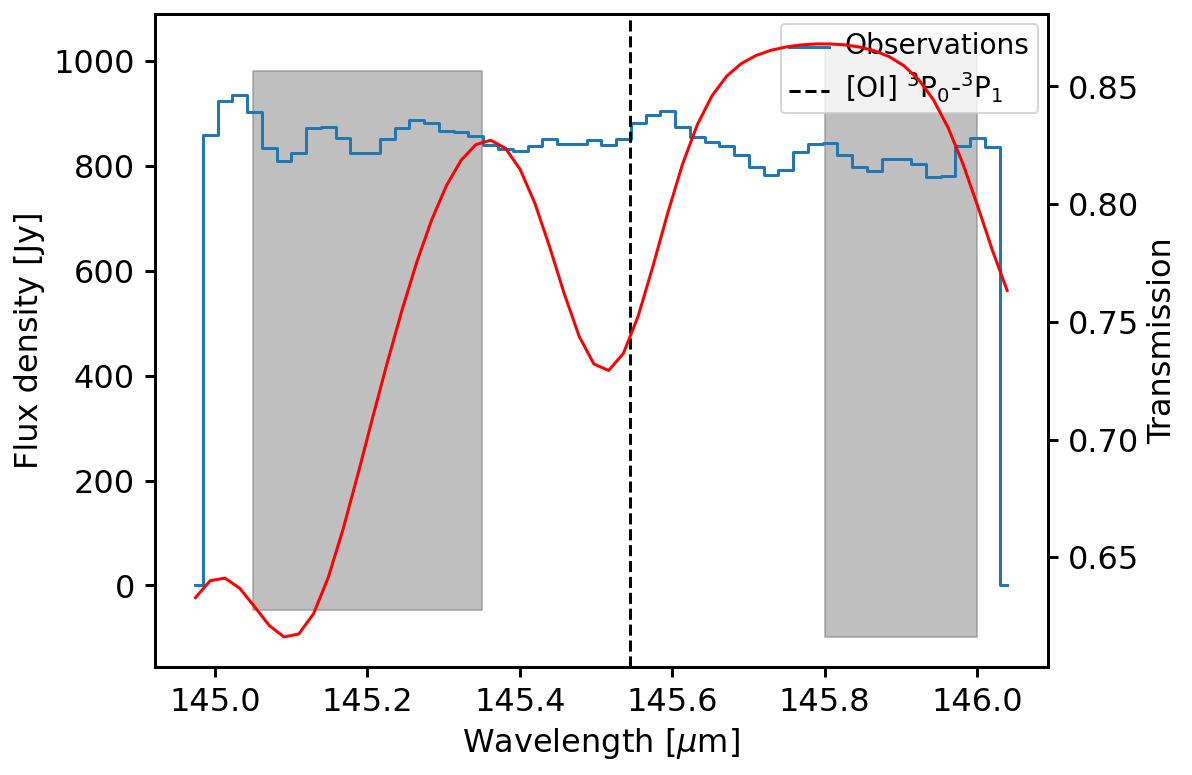

In [32]:
# Construct the flux/wavelength array
wave = ((np.arange(hdu[1].header['NAXIS3'])+1)-hdu[1].header['CRPIX3']) * hdu[1].header['CDELT3'] + hdu[1].header['CRVAL3']

# Churchwell+1992: 13CO 1-0 -> 39.4; 13CO 2-1 -> 39.9; CS 2-1 -> 39.7; CS 5-4 -> 38.5
v_source = 39.4 # km/s
iwave = np.argsort(abs(line_waves-np.mean(wave)))[0]
line_wave = line_waves[iwave]
line_wave_v_source = line_wave * (1+v_source/c*1e5)

fig = plt.figure()
ax = fig.add_subplot(111)

n_pixel = mod_cube.shape[1]
ax.plot(wave, np.nansum(np.nansum(mod_cube[:,n_pixel//2-4:n_pixel//2+4, n_pixel//2-4:n_pixel//2+4], axis=1), axis=1), drawstyle='steps-mid', label='Observations')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel('Flux density [Jy]')
ax.axvline(line_wave_v_source, color='k', linestyle='--', label=line_labels[iwave])

# choose the continuum range
ax.fill_betweenx(ax.get_ylim(), 145.05, 145.35, color='Gray', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 145.8, 146.0, color='Gray', alpha=0.5)

# ax.fill_betweenx(ax.get_ylim(), 185.6, 185.8, color='Gray', alpha=0.5)
# ax.fill_betweenx(ax.get_ylim(), 186.1, 186.3, color='Gray', alpha=0.5)

ax.legend(loc='best')
fig, ax = publish(fig)

ax2 = ax.twinx()
ax2.plot(wave, trans, label='Transmission', color='r')
ax2.set_ylabel('Transmission')
fig, ax2 = publish(fig, ax=ax2)

In [33]:
cont_regions = [[145.05, 145.35], [145.8, 146.0]]
# cont_regions = [[185.6, 185.8], [186.1, 186.3]]

<div class="alert alert-block alert-info">
Need to double check wuth SOSPEX to see if we can get a line-free spectrum
</div>



# Make continuum (line-free) image

In [34]:
selector = np.zeros_like(wave, dtype='bool')

for _region in cont_regions:
    selector += (wave >= _region[0]) & (wave <= _region[1])
cont_im = np.nanmean(hdu[1].data[selector,:,:], axis=0)
print('Total flux = {:<.2f} Jy'.format(np.nansum(np.nansum(cont_im, axis=0), axis=0)))

Total flux = 2540.35 Jy


/var/folders/d2/xn0qhb7x2p7gqlvz33zdqrsh0000gn/T/ipykernel_52095/4116496428.py:5: RuntimeWarning: Mean of empty slice
  cont_im = np.nanmean(hdu[1].data[selector,:,:], axis=0)


## Continuum image without astrometric correction

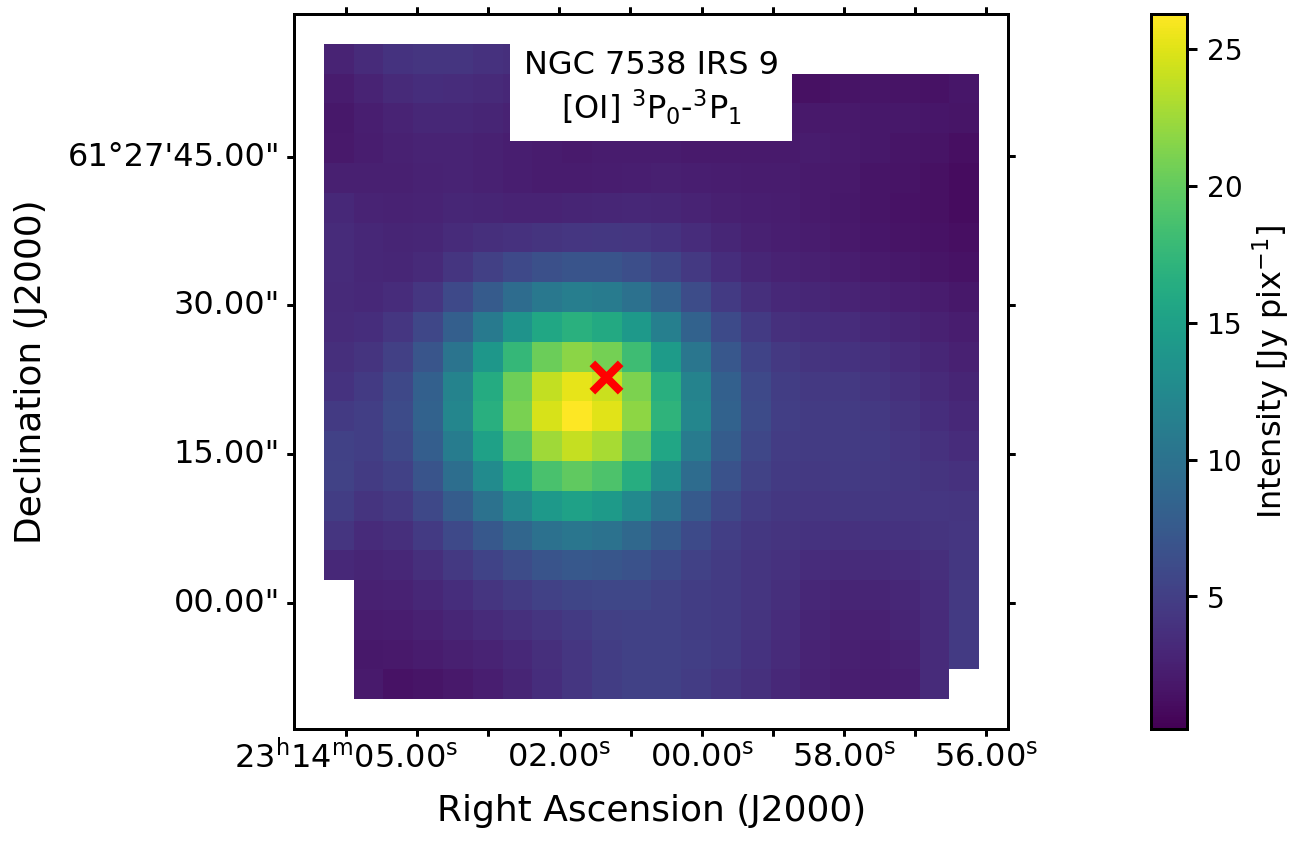

In [35]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
import matplotlib.axes as maxes

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord('23:14:01.77 61:27:19.8', unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

im = ax.imshow(cont_im)

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

iwave = np.argsort(abs(line_waves-np.mean(wave)))[0]
ax.text(0.5, 0.95, source_name+'\n'+line_labels[iwave], ha='center', va='top', transform=ax.transAxes, backgroundcolor='w', fontsize=16)

fig.savefig('/Users/yaolun/Dropbox/research/SOMA-FIR/NGC7538/continuum_no_correction.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Fit with a 2D Gaussian

x_mean = -0.766 +/- 0.039
y_mean = -1.325 +/- 0.036


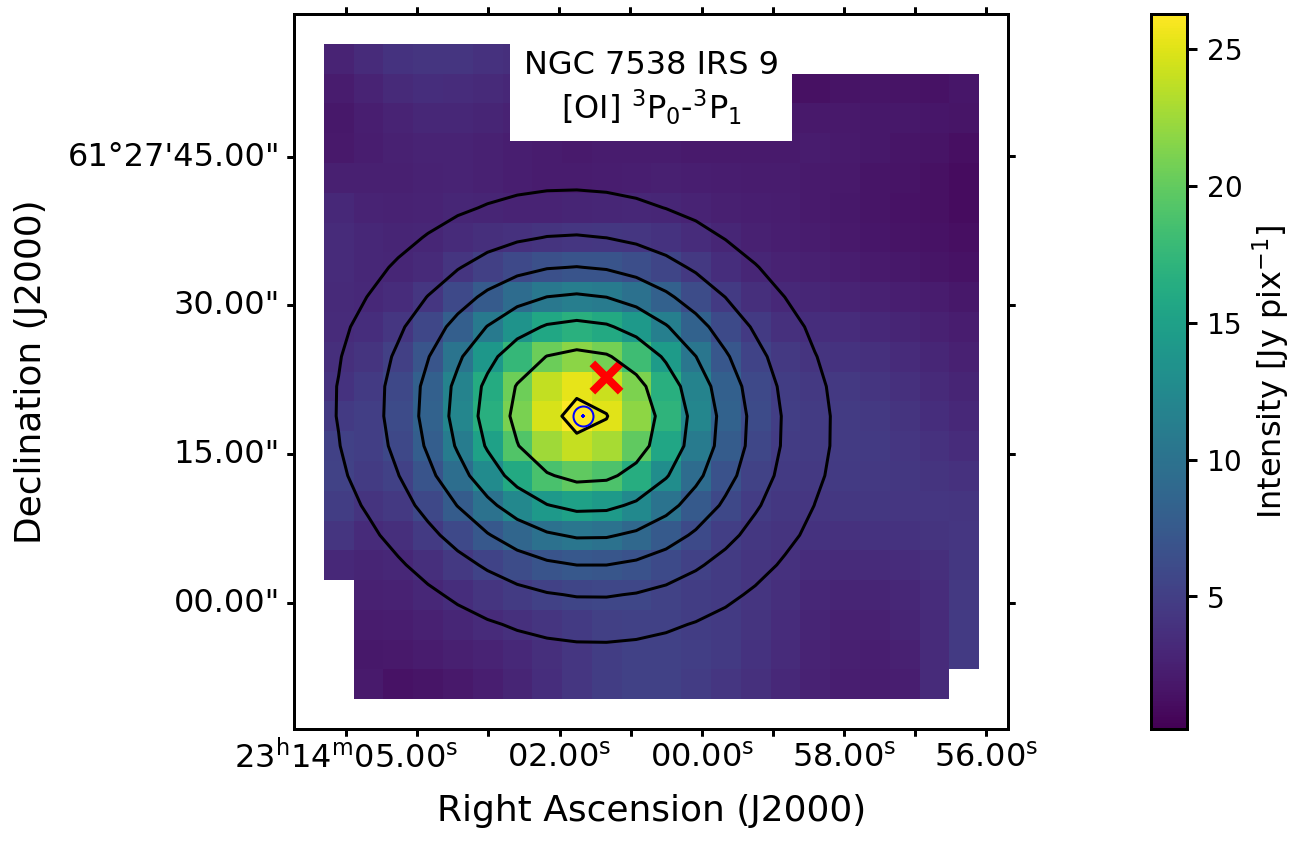

In [36]:
import astropy.io.fits as fits
import os
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

fit = fitting.LevMarLSQFitter()
# initial guess of the fitting parameters
m = models.Gaussian2D(np.nanmax(cont_im), 0, 0, 2, 2)

# Create grids of x- and y-pixels
# Have the source coordinate in here as well, just to be safe
s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000')
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

x_grid, y_grid = np.meshgrid(np.arange(len(cont_im[0,:])), np.arange(len(cont_im[:,0])))
dist_grid = ((x_grid-s_pix[0])**2 + (y_grid-s_pix[1])**2)**0.5
xi = x_grid-s_pix[0]
yi = y_grid-s_pix[1]

# fitting - set NaN value to zero
g = fit(m, xi, yi, np.where(~np.isnan(cont_im), cont_im, 0.0))
# print(g)
print( 'x_mean = {:<.3f} +/- {:<.3f}'.format(g.x_mean.value, fit.fit_info['cov_x'][1,1]**0.5) )
print( 'y_mean = {:<.3f} +/- {:<.3f}'.format(g.y_mean.value, fit.fit_info['cov_x'][2,2]**0.5) )
model_data = g(xi, yi)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

ax.imshow(cont_im)
ax.contour(model_data, colors='k')
ax.errorbar(g.x_mean.value+s_pix[0], g.y_mean.value+s_pix[1], 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)
iwave = np.argsort(abs(line_waves-np.mean(wave)))[0]
ax.text(0.5, 0.95, source_name+'\n'+line_labels[iwave], ha='center', va='top', transform=ax.transAxes, backgroundcolor='w', fontsize=16)

fig.savefig('/Users/yaolun/Dropbox/research/SOMA-FIR/NGC7538/continuum_fitting_no_correction.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Calculate the offset

In [37]:
from astropy.wcs import utils

x_offset_red, y_offset_red = [g.x_mean.value, g.y_mean.value] # in pixel
x_offset_err_red, y_offset_err_red = [fit.fit_info['cov_x'][1,1]**0.5, fit.fit_info['cov_x'][2,2]**0.5]
pltscale = utils.proj_plane_pixel_scales(w) # width of a pixel in degree
x_offset_arcsec, y_offset_arcsec = [x_offset_red*pltscale[0]*3600, y_offset_red*pltscale[0]*3600]
x_offset_err_arcsec, y_offset_err_arcsec = [x_offset_err_red*pltscale[0]*3600, y_offset_err_red*pltscale[0]*3600]

# Recall that RA goes from positivie to negative from left to right
print('Offset in x and y (arcsec, arcsec) = ({:<.2f}+/-{:<.2f}, {:<.2f}+/-{:<.2f})'.format(x_offset_arcsec, x_offset_err_arcsec, 
                                                                                           y_offset_arcsec, y_offset_err_arcsec))

# save the offset
x_offset_red_arcsec = x_offset_arcsec
y_offset_red_arcsec = y_offset_arcsec
x_offset_err_red_arcsec = x_offset_err_arcsec
y_offset_err_red_arcsec = y_offset_err_arcsec

Offset in x and y (arcsec, arcsec) = (-2.30+/-0.12, -3.97+/-0.11)


## Continuum image WITH astrometric correction

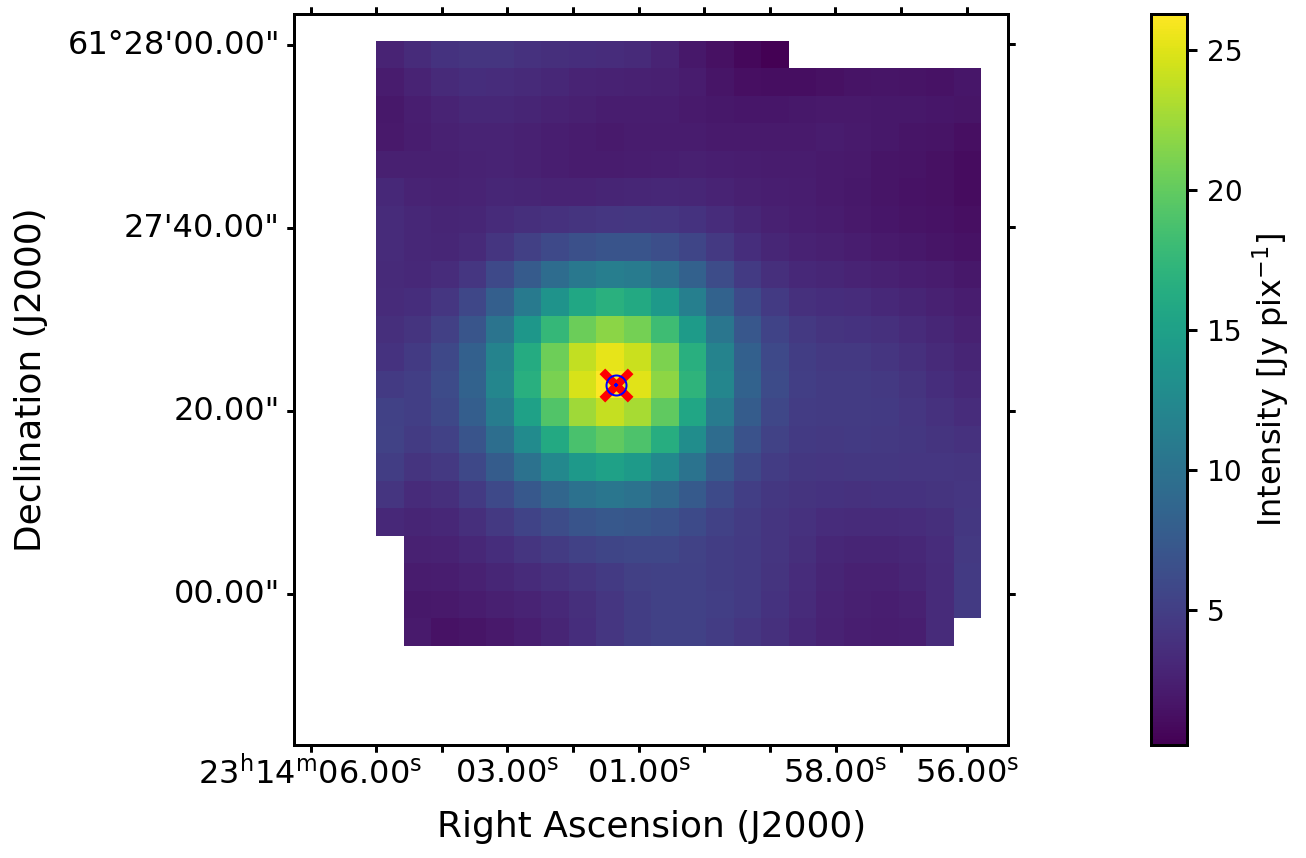

In [38]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.ndimage import shift
import matplotlib.axes as maxes

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

# make an image with correction to get the extent
im = ax.imshow(cont_im)
extent = im.get_extent()
# reset the extent with astrometric correction
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, 
                       extent[2]-y_offset_red, extent[3]-y_offset_red])

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

# source position
ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# where the peak of the 2D gaussian supposed to be
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

fig.savefig('/Users/yaolun/Dropbox/research/SOMA-FIR/NGC7538/contiuum_145um_corrected.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Take out the fitted Gaussian

Gaussian peak = 21.45
Image peak = 26.27
Noise = 1.77
Peak residual = 4.85
S/N = 12.15
Thermal noise = 0.53 arcsec


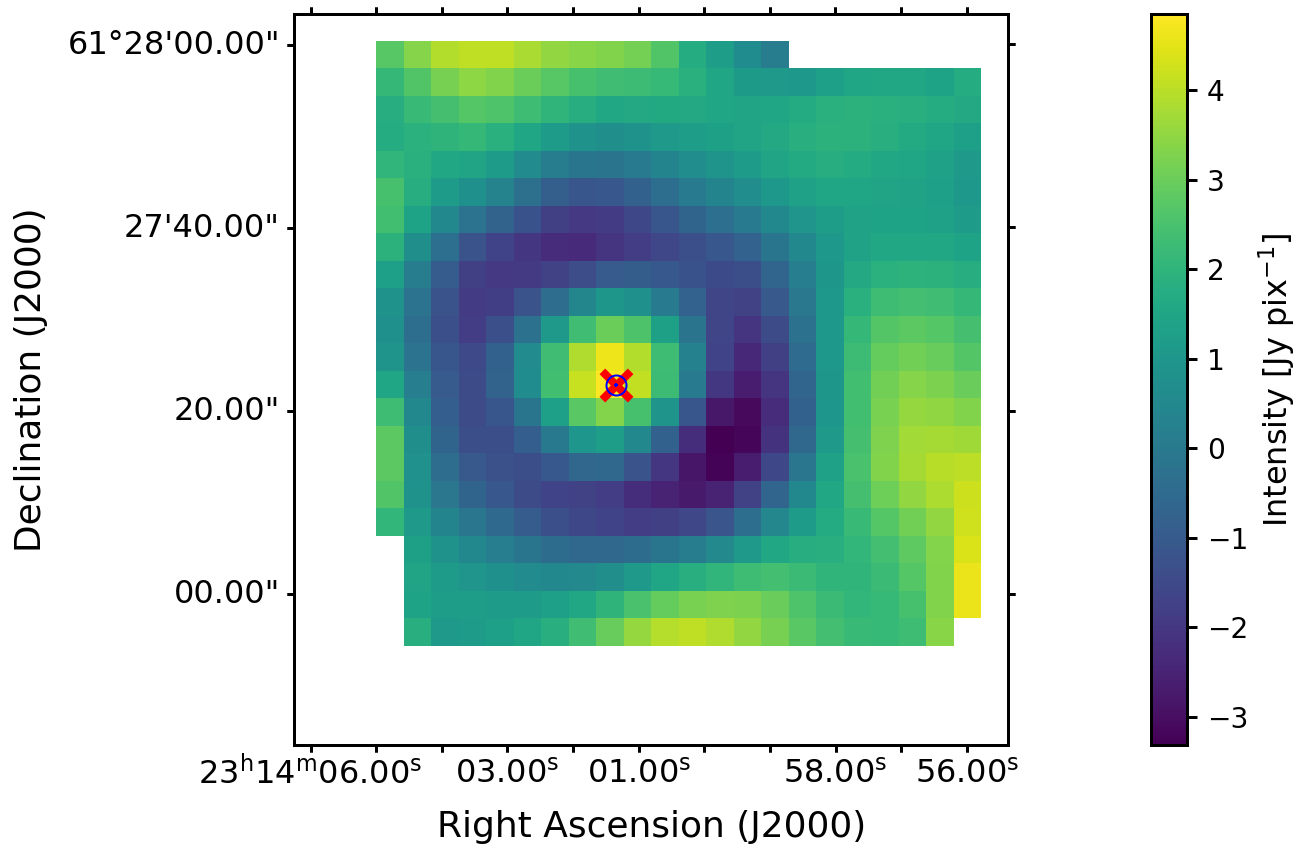

In [39]:
import astropy.io.fits as fits
import os
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
import matplotlib.axes as maxes
from mpl_toolkits.axes_grid1 import make_axes_locatable


s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

im = ax.imshow(cont_im-model_data)
extent = im.get_extent()
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, 
                       extent[2]-y_offset_red, extent[3]-y_offset_red])

# ax.contour(model_data, colors='k')
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

# print the S/N of the continuum
cont_red_noise = np.nanstd(cont_im-model_data)
snr_red = g.amplitude.value/cont_red_noise
print('Gaussian peak = {:<.2f}'.format(g.amplitude.value))
print('Image peak = {:<.2f}'.format(np.nanmax(cont_im)))
print('Noise = {:<.2f}'.format(cont_red_noise))
print('Peak residual = {:<.2f}'.format(np.nanmax(cont_im-model_data)))
print('S/N = {:<.2f}'.format(snr_red))

# from Reid and Honma 2014, thermal noise = 0.5*θ_beam/SNR
beam = 14 * (1.9/ (c/line_wave*1e4/1e12))
print('Thermal noise = {:<.2f} arcsec'.format(0.5*beam/snr_red))

# Masking out the continuum source to estimate the noise

Gaussian peak = 21.45
Image peak = 26.27
Noise = 2.18
Peak residual = 11.87
S/N = 9.86
Thermal noise = 0.65 arcsec


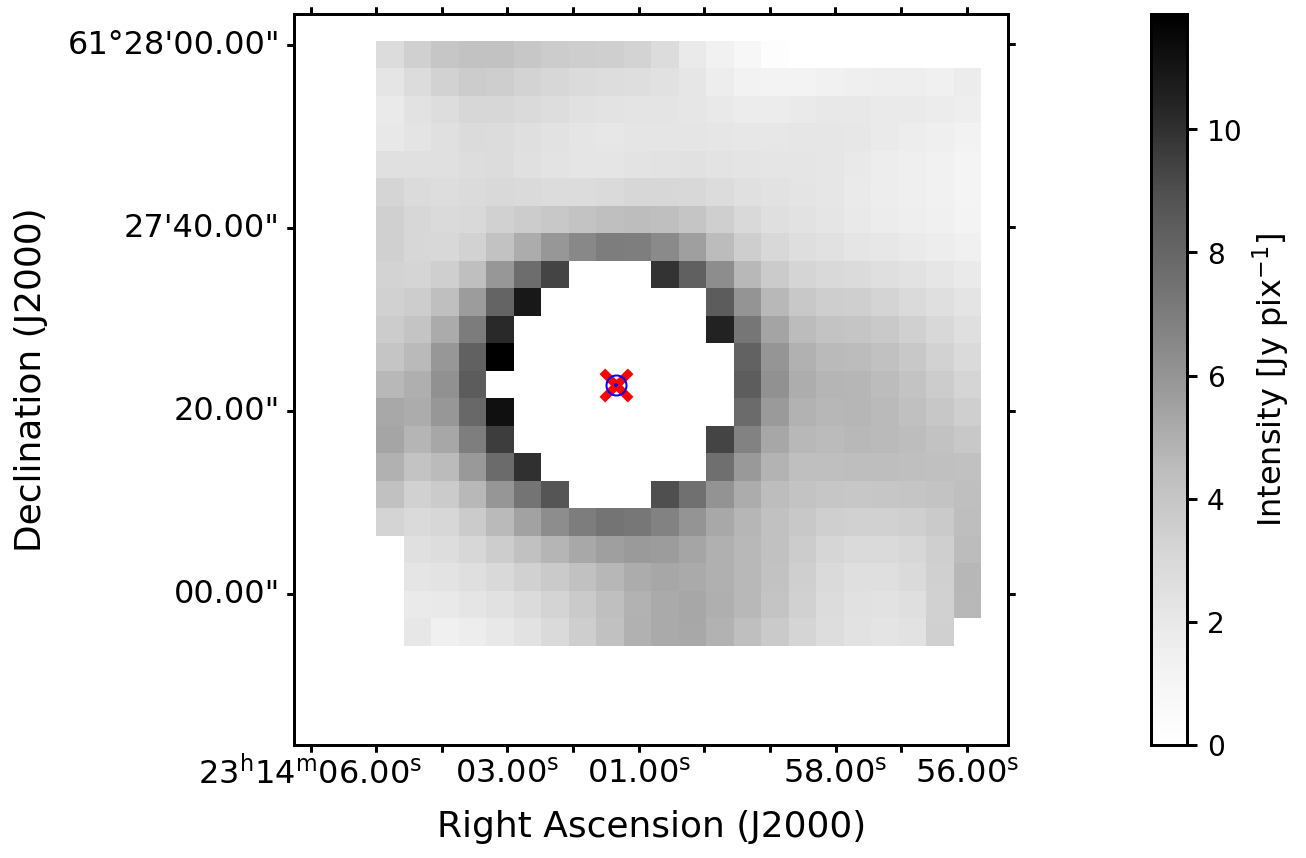

In [40]:
import astropy.io.fits as fits
import os
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
import matplotlib.axes as maxes
from mpl_toolkits.axes_grid1 import make_axes_locatable

s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

# masking
aper = 25.6

x_grid, y_grid = np.meshgrid(np.arange(len(cont_im[0,:])), np.arange(len(cont_im[:,0])))
dist_grid = ((x_grid-s_pix[0]-x_offset_red)**2 + (y_grid-s_pix[1]-y_offset_red
                                                 )**2)**0.5
aper_pix = aper / ( abs(utils.proj_plane_pixel_scales(w)[0])*3600 )
cont_im_masked = np.where(dist_grid <= aper_pix/2, cont_im, 0.0)
cont_im_bkg = np.where(dist_grid > aper_pix/2, cont_im, 0.0)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

im = ax.imshow(cont_im_bkg, cmap='Greys')
extent = im.get_extent()
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, 
                       extent[2]-y_offset_red, extent[3]-y_offset_red])

# ax.contour(model_data, colors='k')
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

# print the S/N of the continuum
cont_bkg_red_noise = np.nanstd(cont_im_bkg)
snr_red = g.amplitude.value/cont_bkg_red_noise
print('Gaussian peak = {:<.2f}'.format(g.amplitude.value))
print('Image peak = {:<.2f}'.format(np.nanmax(cont_im)))
print('Noise = {:<.2f}'.format(cont_bkg_red_noise))
print('Peak residual = {:<.2f}'.format(np.nanmax(cont_im_bkg)))
print('S/N = {:<.2f}'.format(snr_red))

# from Reid and Honma 2014, thermal noise = 0.5*θ_beam/SNR
beam = 14 * (1.9/ (c/line_wave*1e4/1e12))
print('Thermal noise = {:<.2f} arcsec'.format(0.5*beam/snr_red))

# Make cont-free spectral cube

In [41]:
# cube = hdu[3].data  # redo the transmission correction
contsub_cube_red = np.zeros_like(mod_cube)
for i in range(len(mod_cube[:,0,0])):
    contsub_cube_red[i,:,:] = mod_cube[i,:,:] - cont_im

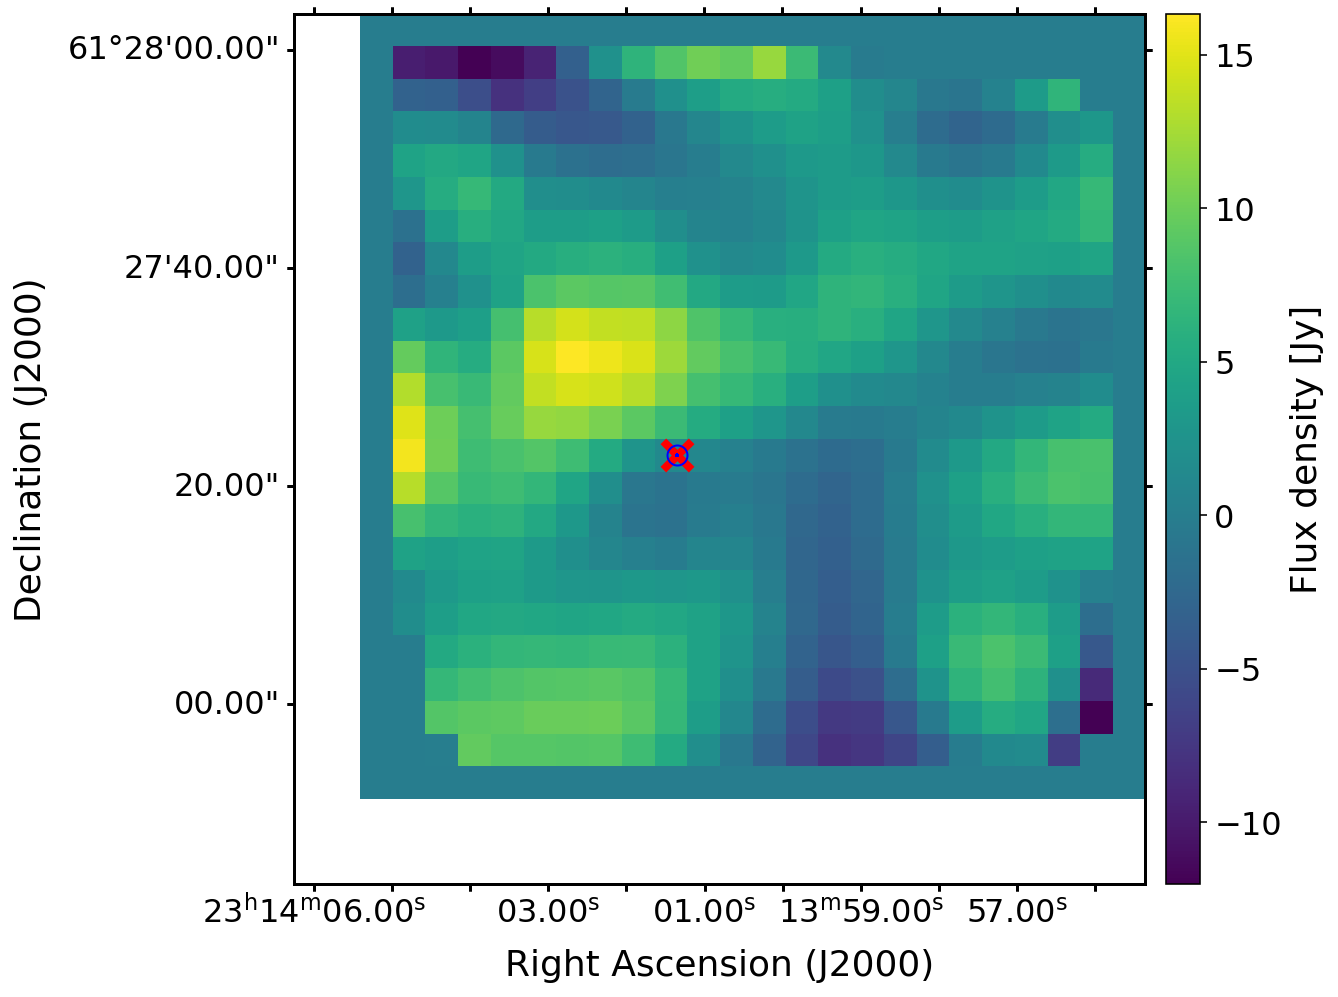

In [42]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.ndimage import shift

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

# find where the line is
velo = (wave-line_wave)/line_wave * c/1e5 - v_source
selector = (velo < 150) & (velo > -150)

# make an image with correction to get the extent
contsub_im = np.nansum(contsub_cube_red[selector,:,:], axis=0)
im = ax.imshow(contsub_im)
extent = im.get_extent()
# reset the extent with astrometric correction
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, extent[2]-y_offset_red, extent[3]-y_offset_red])

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

# source position
ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# where the peak of the 2D gaussian supposed to be
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)


cax = fig.add_axes([0.9,0.125,0.03,0.755])
cb=fig.colorbar(im, cax=cax)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

# Make blue- and red- integrated intensity

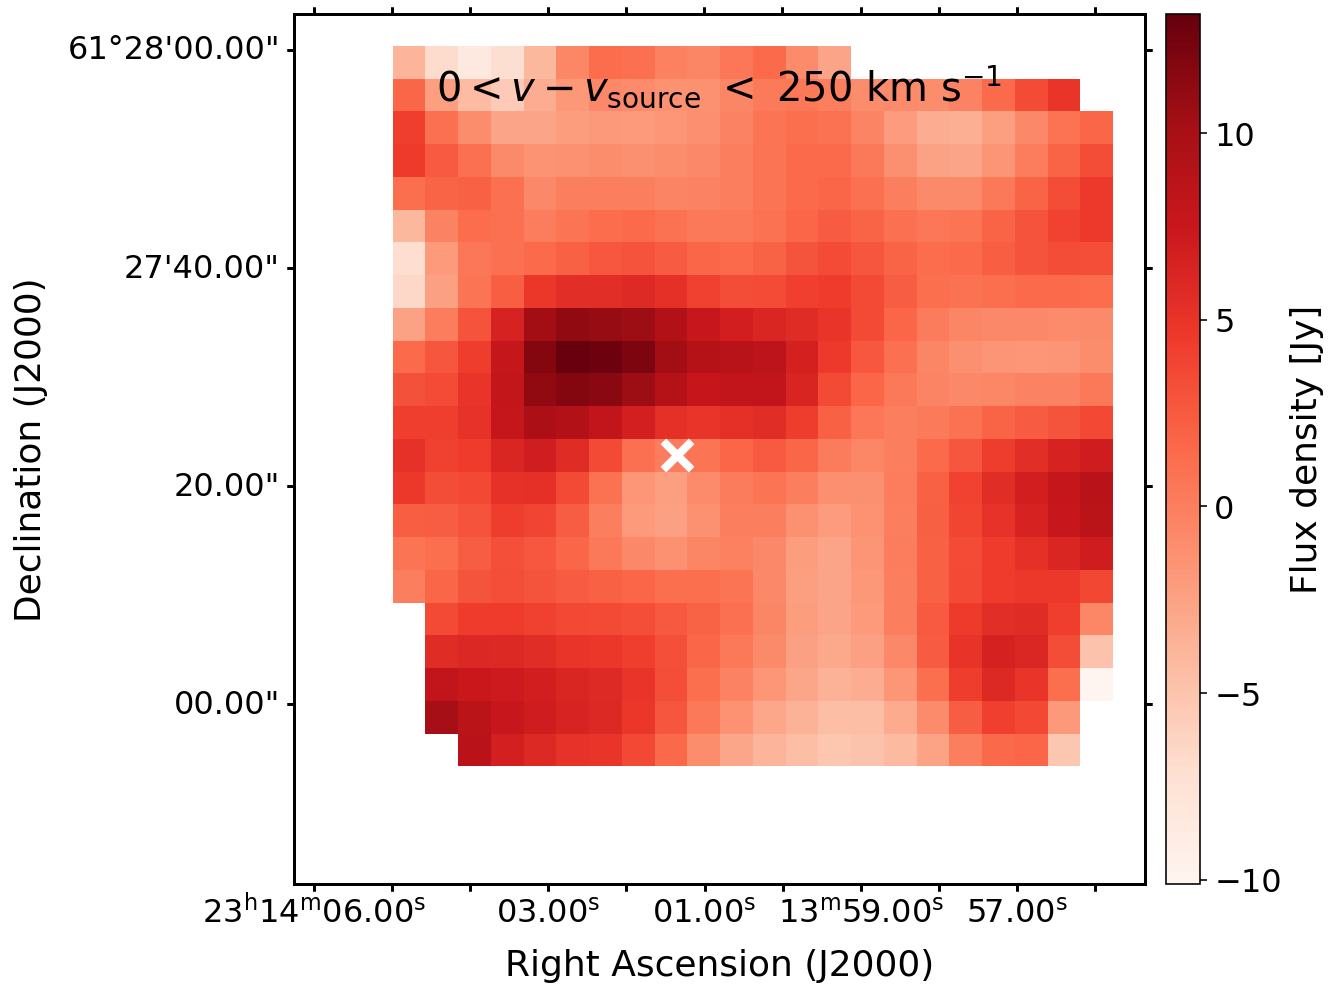

In [43]:
coords = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 

wcs = WCS(naxis=2)
wcs.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
wcs.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
wcs.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
wcs.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

# Churchwell+1992: 13CO 1-0 -> 39.4; 13CO 2-1 -> 39.9; CS 2-1 -> 39.7; CS 5-4 -> 38.5
v_source = 39.4 # km/s
iwave = np.argsort(abs(line_waves-np.mean(wave)))[0]
line_wave = line_waves[iwave]

velo = (wave-line_wave)/line_wave * c/1e5 - v_source
velo_red = (velo > 0) & (velo < 250)
velo_blue = (velo < 0) & (velo > -250)

wave_indice = np.arange(0, len(contsub_cube_red[:,0,0]))
red_indice = wave_indice[velo_red]
blue_indice = wave_indice[velo_blue]

fig = make_image(np.sum(contsub_cube_red[red_indice,:,:], axis=0), coords, wcs, 
                 astrometry_corr=[x_offset_red, y_offset_red], 
                 velo_label=r'$0 < v - v_{\rm source}$ $<$ 250 km s$^{-1}$', cmap='Reds')
# fig.savefig('/Users/yaolun/GoogleDrive/research/SOMA-FIR/NGC7538/OI63_red.pdf',
#             format='pdf', dpi=300, bbox_inches='tight')

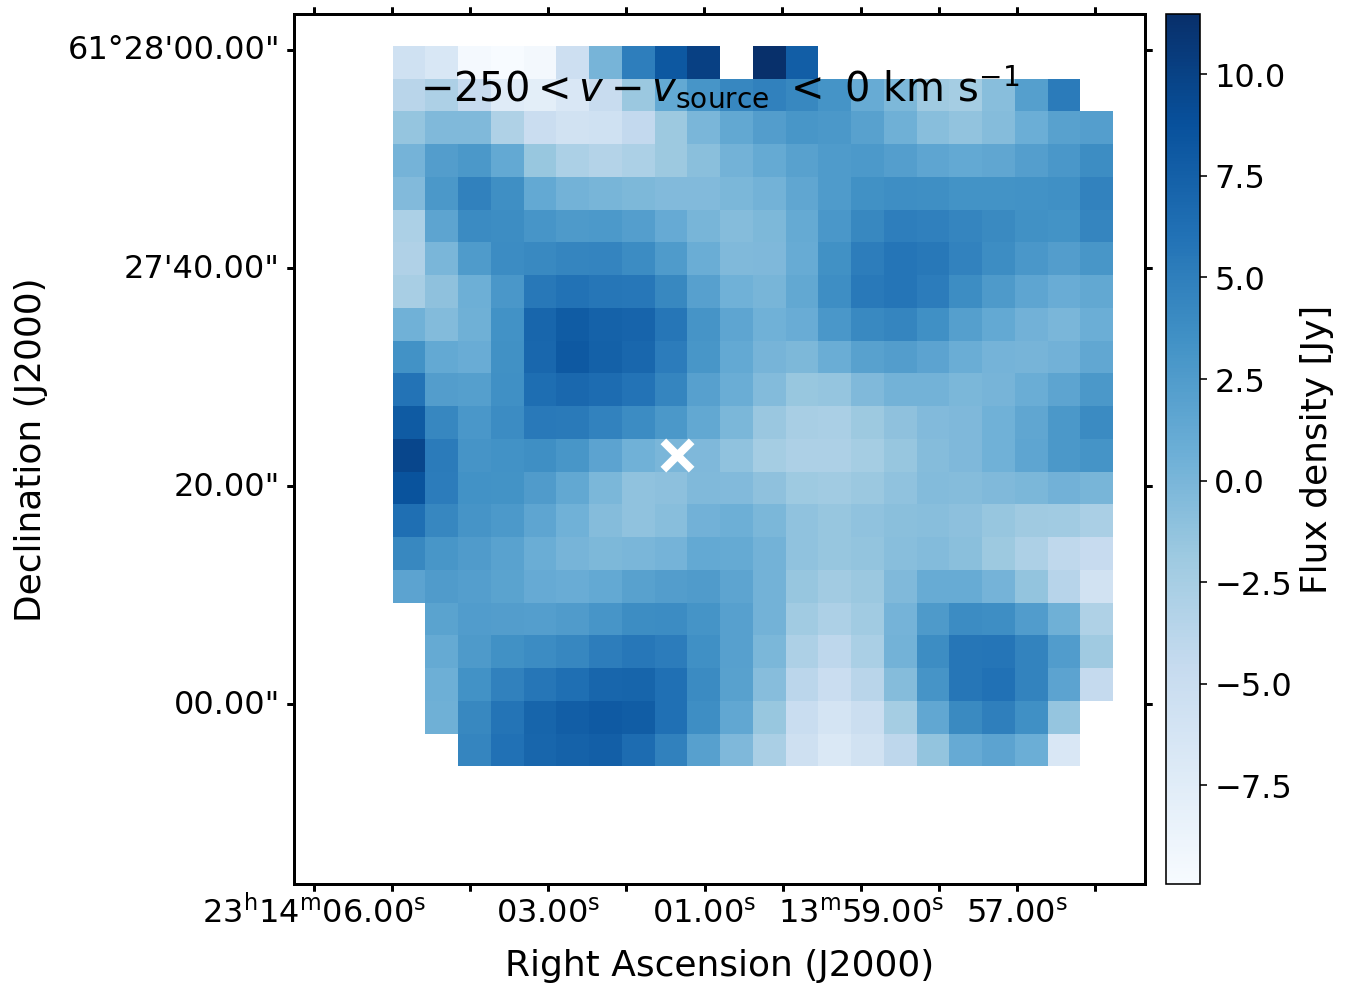

In [44]:
fig = make_image(np.sum(contsub_cube_red[blue_indice,:,:], axis=0), coords, wcs, 
                 astrometry_corr=[x_offset_red, y_offset_red], 
                 velo_label=r'$-250 < v - v_{\rm source}$ $<$ 0 km s$^{-1}$', cmap='Blues')
# fig.savefig('/Users/yaolun/GoogleDrive/research/SOMA-FIR/NGC7538/OI63_blue.pdf',
#             format='pdf', dpi=300, bbox_inches='tight')

# Open the spectral cube - BLUE

In [40]:
hdu = fits.open('/Users/yaolun/Dropbox/research/SOMA-FIR/fits/F0740_FI_IFS_09016939_BLU_WXY_00055-00080.fits')
print (hdu[0].header['OBJECT'], '{:<.1f} um'.format(hdu[1].header['CRVAL3']))

NGC_7538_IRS_9 63.0 um


In [41]:
if abs(hdu[1].header['CRVAL3']-63) < 5:

    cube = hdu[3].data  # redo the transmission correction
    trans = hdu[8].data
    mod_cube = np.zeros_like(cube)
    for i in range(len(cube[:,0,0])):
        mod_cube[i,:,:] = cube[i,:,:]/trans[i]
else:
    mod_cube = hdu[1].data
    trans = hdu[8].data

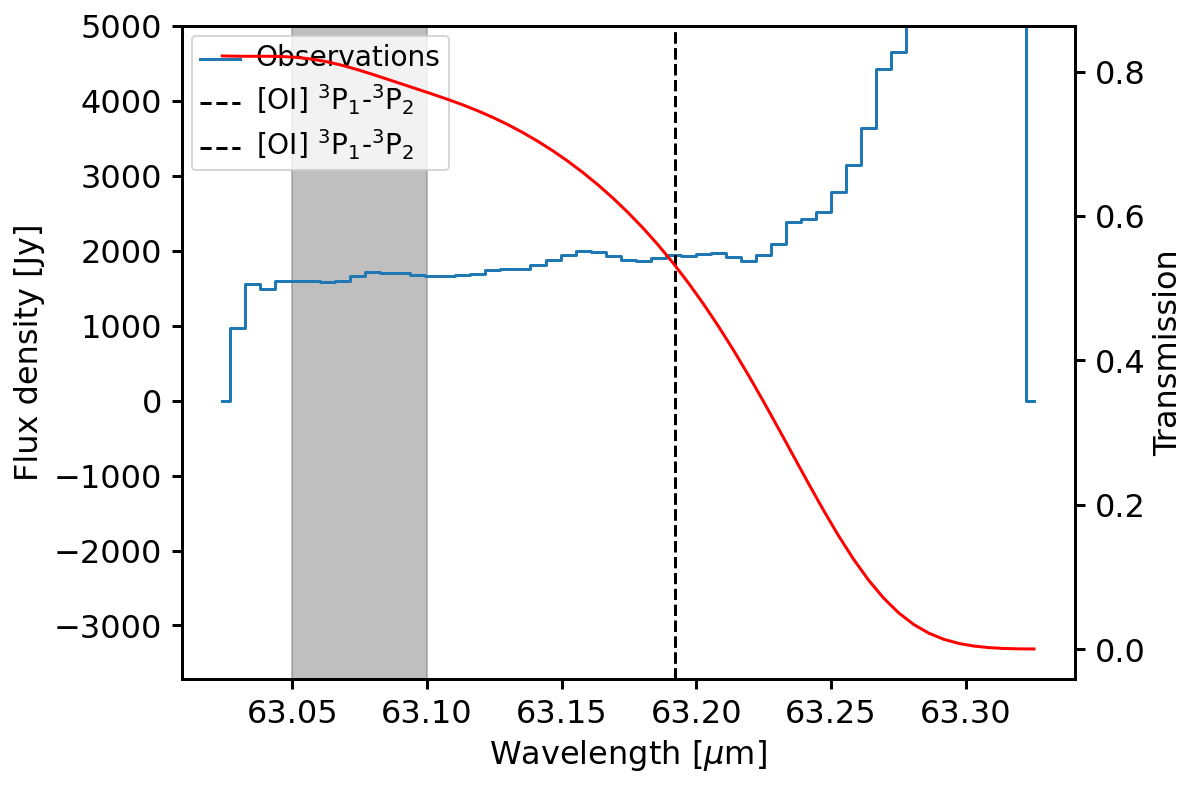

In [42]:
# Construct the flux/wavelength array
wave = ((np.arange(hdu[1].header['NAXIS3'])+1)-hdu[1].header['CRPIX3']) * hdu[1].header['CDELT3'] + hdu[1].header['CRVAL3']

# Churchwell+1992: 13CO 1-0 -> 39.4; 13CO 2-1 -> 39.9; CS 2-1 -> 39.7; CS 5-4 -> 38.5
v_source = 39.4 # km/s
iwave = np.argsort(abs(line_waves-np.mean(wave)))[0]
line_wave = line_waves[iwave]
line_wave_v_source = line_wave * (1+v_source/c*1e5)
line_wave_v_source_vlim = (np.array([-250, 250])+v_source)/c*1e5

fig = plt.figure()
ax = fig.add_subplot(111)

n_pixel = mod_cube.shape[1]
ax.plot(wave, np.nansum(np.nansum(mod_cube[:,n_pixel//2-4:n_pixel//2+4, n_pixel//2-4:n_pixel//2+4], axis=1), axis=1), drawstyle='steps-mid', label='Observations')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel('Flux density [Jy]')
ax.axvline(line_wave_v_source, color='k', linestyle='--', label=line_labels[iwave])
ax.axvline(line_wave_v_source, color='k', linestyle='--', label=line_labels[iwave])
ax.set_ylim(top=5000)

# choose the continuum range
ax.fill_betweenx(ax.get_ylim(), 63.05, 63.10, color='Gray', alpha=0.5)
# ax.fill_betweenx(ax.get_ylim(), 63.25, 63.26, color='Gray', alpha=0.5)
ax.legend(loc='best')
fig, ax = publish(fig)

ax2 = ax.twinx()
ax2.plot(wave, trans, label='Transmission', color='r')
ax2.set_ylabel('Transmission')
fig, ax2 = publish(fig, ax=ax2)

In [43]:
cont_regions = [[63.05, 63.10]]

<div class="alert alert-block alert-info">
Need to double check wuth SOSPEX to see if we can get a line-free spectrum
</div>



# Make continuum (line-free) image

In [44]:
selector = np.zeros_like(wave, dtype='bool')

for _region in cont_regions:
    selector += (wave >= _region[0]) & (wave <= _region[1])
cont_im = np.nanmean(hdu[1].data[selector,:,:], axis=0)
print('Total flux = {:<.2f} Jy'.format(np.nansum(np.nansum(cont_im, axis=0), axis=0)))

Total flux = 1822.56 Jy


/var/folders/d2/xn0qhb7x2p7gqlvz33zdqrsh0000gn/T/ipykernel_18405/4116496428.py:5: RuntimeWarning: Mean of empty slice
  cont_im = np.nanmean(hdu[1].data[selector,:,:], axis=0)


## Continuum image without astrometric correction

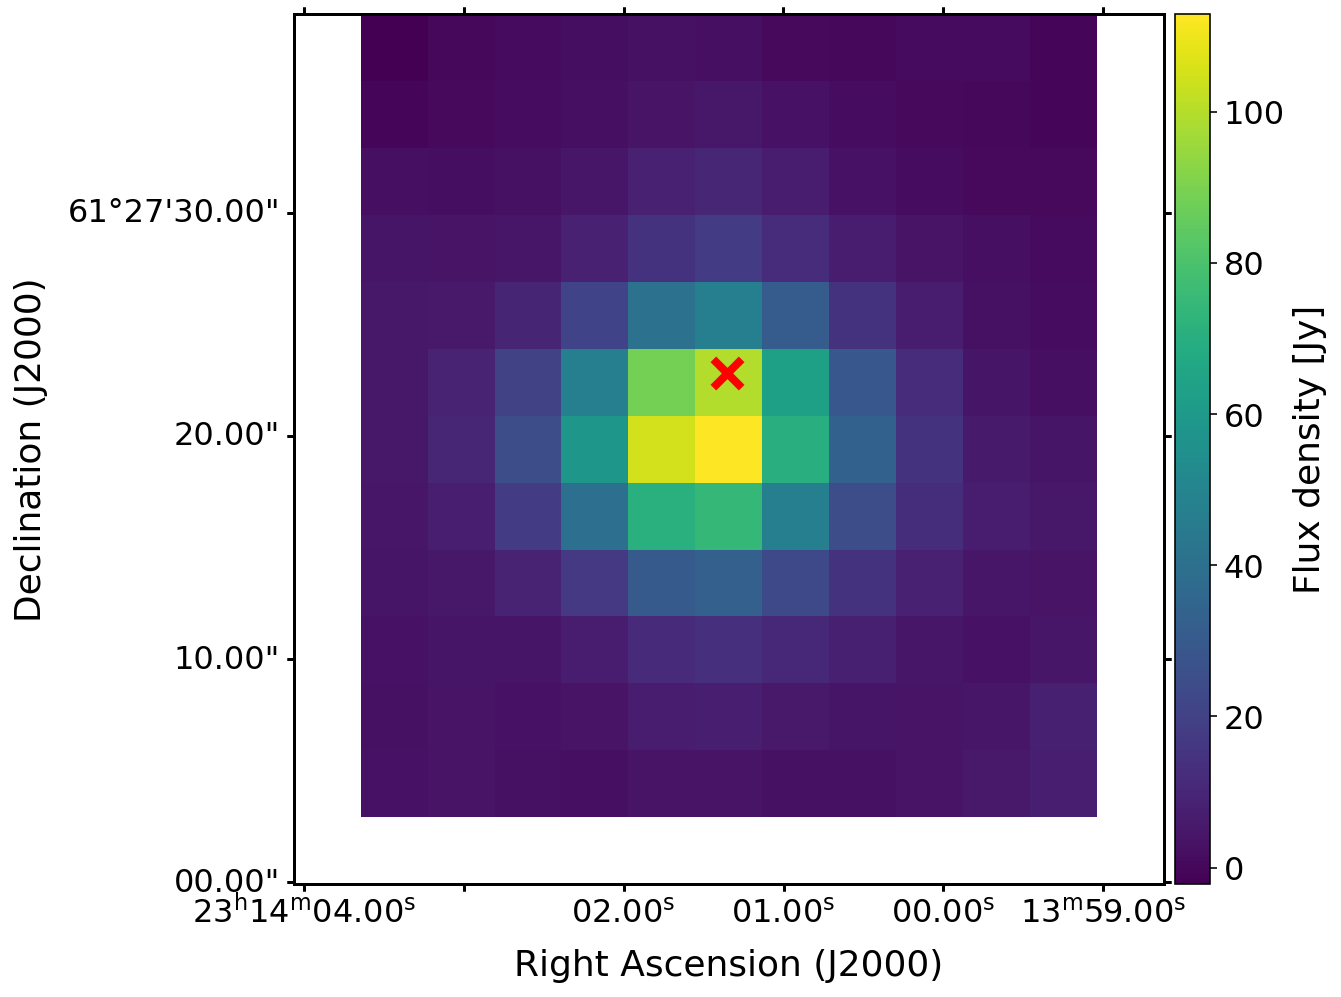

In [208]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

im = ax.imshow(cont_im)

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)


ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)


cax = fig.add_axes([0.9,0.125,0.03,0.755])
cb=fig.colorbar(im, cax=cax)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

# Fit with a 2D Gaussian

x_mean = -0.299 +/- 0.007
y_mean = -0.934 +/- 0.007


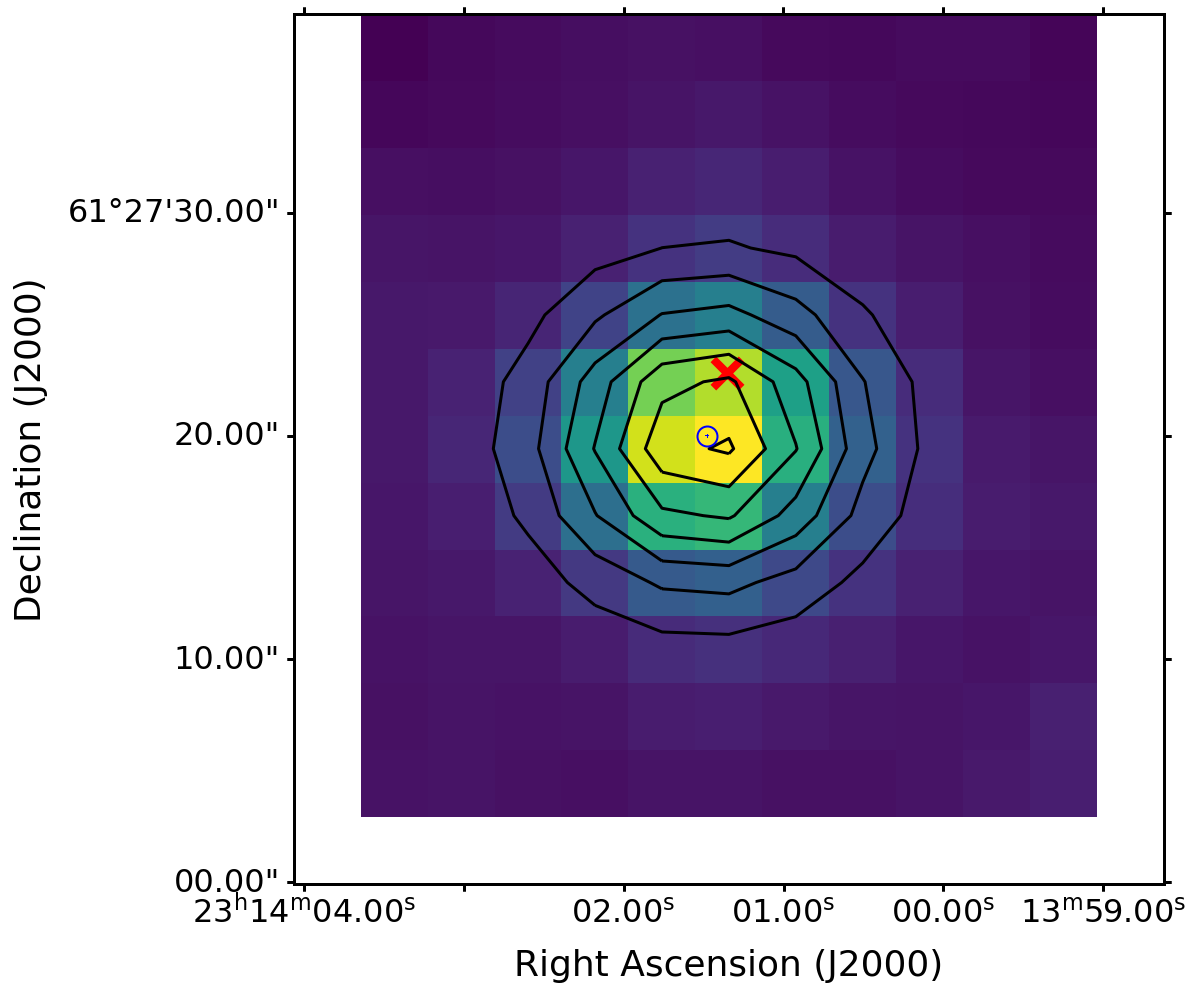

In [209]:
import astropy.io.fits as fits
import os
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 

fit = fitting.LevMarLSQFitter()
# initial guess of the fitting parameters
m = models.Gaussian2D(np.nanmax(cont_im), 0, 0, 2, 2)

# Create grids of x- and y-pixels
# Have the source coordinate in here as well, just to be safe
s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

x_grid, y_grid = np.meshgrid(np.arange(len(cont_im[0,:])), np.arange(len(cont_im[:,0])))
dist_grid = ((x_grid-s_pix[0])**2 + (y_grid-s_pix[1])**2)**0.5
xi = x_grid-s_pix[0]
yi = y_grid-s_pix[1]

# fitting - set NaN value to zero
g = fit(m, xi, yi, np.where(~np.isnan(cont_im), cont_im, 0.0))
# print(g)
print( 'x_mean = {:<.3f} +/- {:<.3f}'.format(g.x_mean.value, fit.fit_info['cov_x'][1,1]**0.5) )
print( 'y_mean = {:<.3f} +/- {:<.3f}'.format(g.y_mean.value, fit.fit_info['cov_x'][2,2]**0.5) )
model_data = g(xi, yi)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

ax.imshow(cont_im)
ax.contour(model_data, colors='k')
ax.errorbar(g.x_mean.value+s_pix[0], g.y_mean.value+s_pix[1], 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# Calculate the offset

In [210]:
from astropy.wcs import utils

x_offset_blue, y_offset_blue = [g.x_mean.value, g.y_mean.value] # in pixel
x_offset_err_blue, y_offset_err_blue = [fit.fit_info['cov_x'][1,1]**0.5, fit.fit_info['cov_x'][2,2]**0.5]
pltscale = utils.proj_plane_pixel_scales(w) # width of a pixel in degree
x_offset_blue_arcsec, y_offset_blue_arcsec = [x_offset_blue*pltscale[0]*3600, y_offset_blue*pltscale[0]*3600]
x_offset_err_blue_arcsec, y_offset_err_blue_arcsec = [x_offset_err_blue*pltscale[0]*3600, y_offset_err_blue*pltscale[0]*3600]

# Recall that RA goes from positivie to negative from left to right
print('[BLUE] - Offset in x and y (arcsec, arcsec)   = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_blue_arcsec, x_offset_err_blue_arcsec, 
                                                                                    y_offset_blue_arcsec, y_offset_err_blue_arcsec))
print('[RED]  - Offset in x and y (arcsec, arcsec)   = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_red_arcsec, x_offset_err_red_arcsec,
                                                                                    y_offset_red_arcsec, y_offset_err_red_arcsec))

# convert the offsets in RED to blue
x_offset_red2blue = x_offset_red_arcsec / (pltscale[0]*3600)
y_offset_red2blue = y_offset_red_arcsec / (pltscale[0]*3600)

print('Relatvie offset in x and y (BLUE from RED)    = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_blue_arcsec-x_offset_red_arcsec, 
                                                                                                          (x_offset_err_blue_arcsec**2 + x_offset_err_red_arcsec**2)**0.5,
                                                                                                          y_offset_blue_arcsec-y_offset_red_arcsec,
                                                                                                          (y_offset_err_blue_arcsec**2 + y_offset_err_red_arcsec**2)**0.5))
print('Relatvie offset in RA and Dec (BLUE from RED) = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(-(x_offset_blue_arcsec-x_offset_red_arcsec), 
                                                                                                          (x_offset_err_blue_arcsec**2 + x_offset_err_red_arcsec**2)**0.5,
                                                                                                          y_offset_blue_arcsec-y_offset_red_arcsec,
                                                                                                          (y_offset_err_blue_arcsec**2 + y_offset_err_red_arcsec**2)**0.5))

# print('IF we consider the 1/3 beam size error - ')
# # 14 x (1.9/ v THz)
# red_beam = 14 * (1.9/1.6) / 3 # 185 um (CO 14-13)
# blue_beam = 14 * (1.9/5.8) / 3 # 52 um ([OIII])
# print('Relatvie offset in x and y (BLUE from RED)    = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_blue_arcsec-x_offset_red_arcsec, 
#                                                                                                           (x_offset_err_blue_arcsec**2 + x_offset_err_red_arcsec**2 + blue_beam**2 + red_beam**2)**0.5,
#                                                                                                           y_offset_blue_arcsec-y_offset_red_arcsec,
#                                                                                                           (y_offset_err_blue_arcsec**2 + y_offset_err_red_arcsec**2 + blue_beam**2 + red_beam**2)**0.5))


[BLUE] - Offset in x and y (arcsec, arcsec)   = (-0.90+/- 0.02, -2.80+/- 0.02)
[RED]  - Offset in x and y (arcsec, arcsec)   = (-2.30+/- 0.12, -3.97+/- 0.11)
Relatvie offset in x and y (BLUE from RED)    = ( 1.40+/- 0.12,  1.17+/- 0.11)
Relatvie offset in RA and Dec (BLUE from RED) = (-1.40+/- 0.12,  1.17+/- 0.11)


## Continuum image WITH astrometric correction

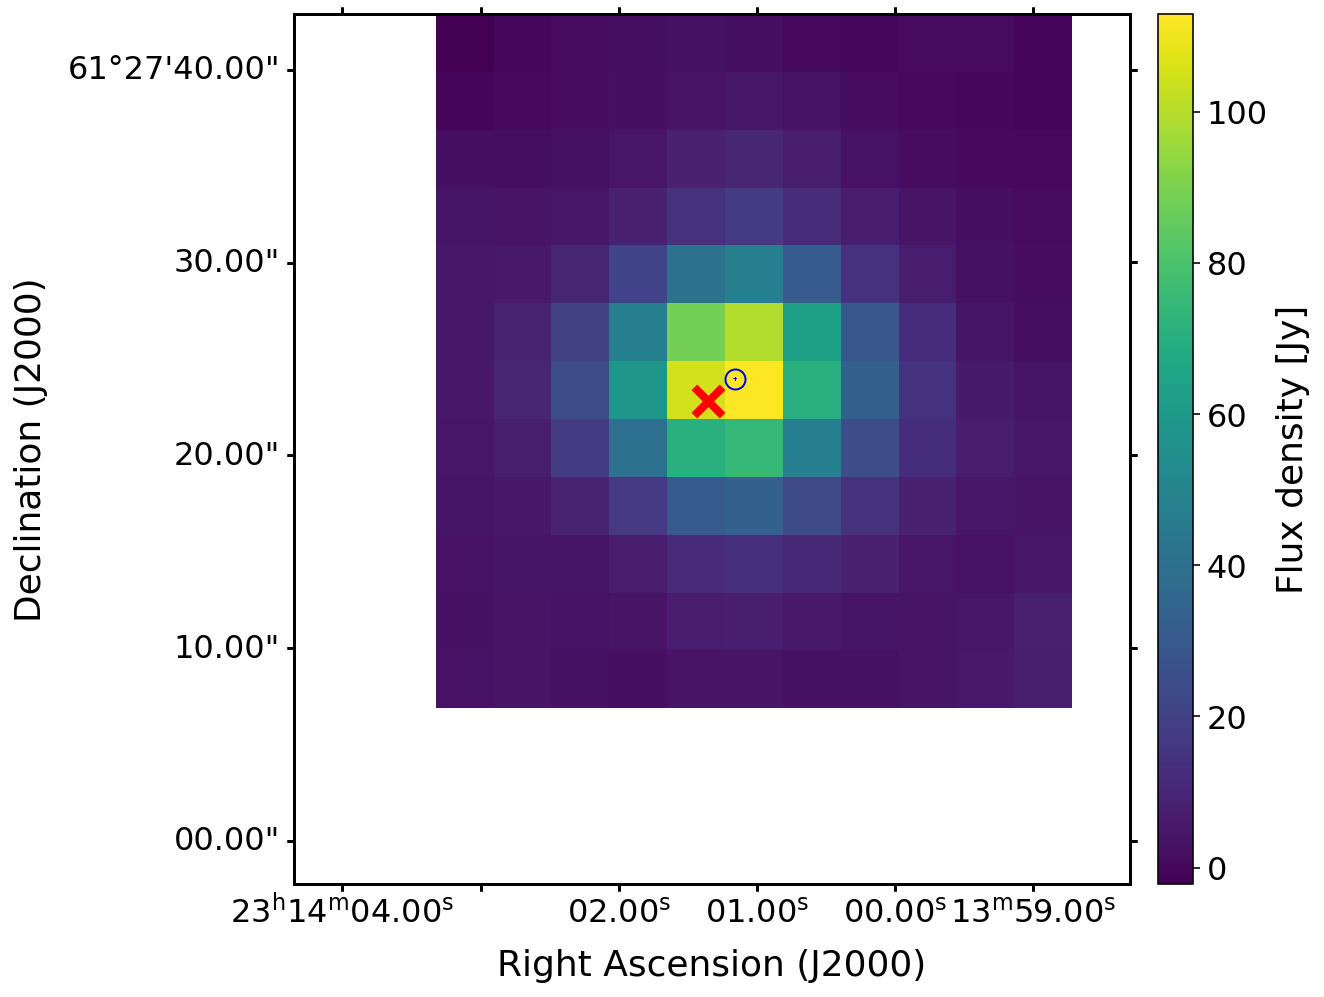

In [211]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.ndimage import shift

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

# make an image with correction to get the extent
im = ax.imshow(cont_im)
extent = im.get_extent()
# actual image with astrometric correction
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, extent[2]-y_offset_red, extent[3]-y_offset_red])

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

# source position
ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# where the peak of the 2D gaussian supposed to be
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)


cax = fig.add_axes([0.9,0.125,0.03,0.755])
cb=fig.colorbar(im, cax=cax)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

fig.savefig('/Users/yaolun/Dropbox/research/SOMA-FIR/NGC7538/contiuum_63um_corrected.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Take out the fitted Gaussian

/var/folders/d2/xn0qhb7x2p7gqlvz33zdqrsh0000gn/T/ipykernel_9277/1198429.py:42: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


Gaussian peak = 110.63
Image peak = 112.92
Noise = 2.81
Peak residual = 7.84
S/N = 39.32
Thermal noise = 0.07 arcsec


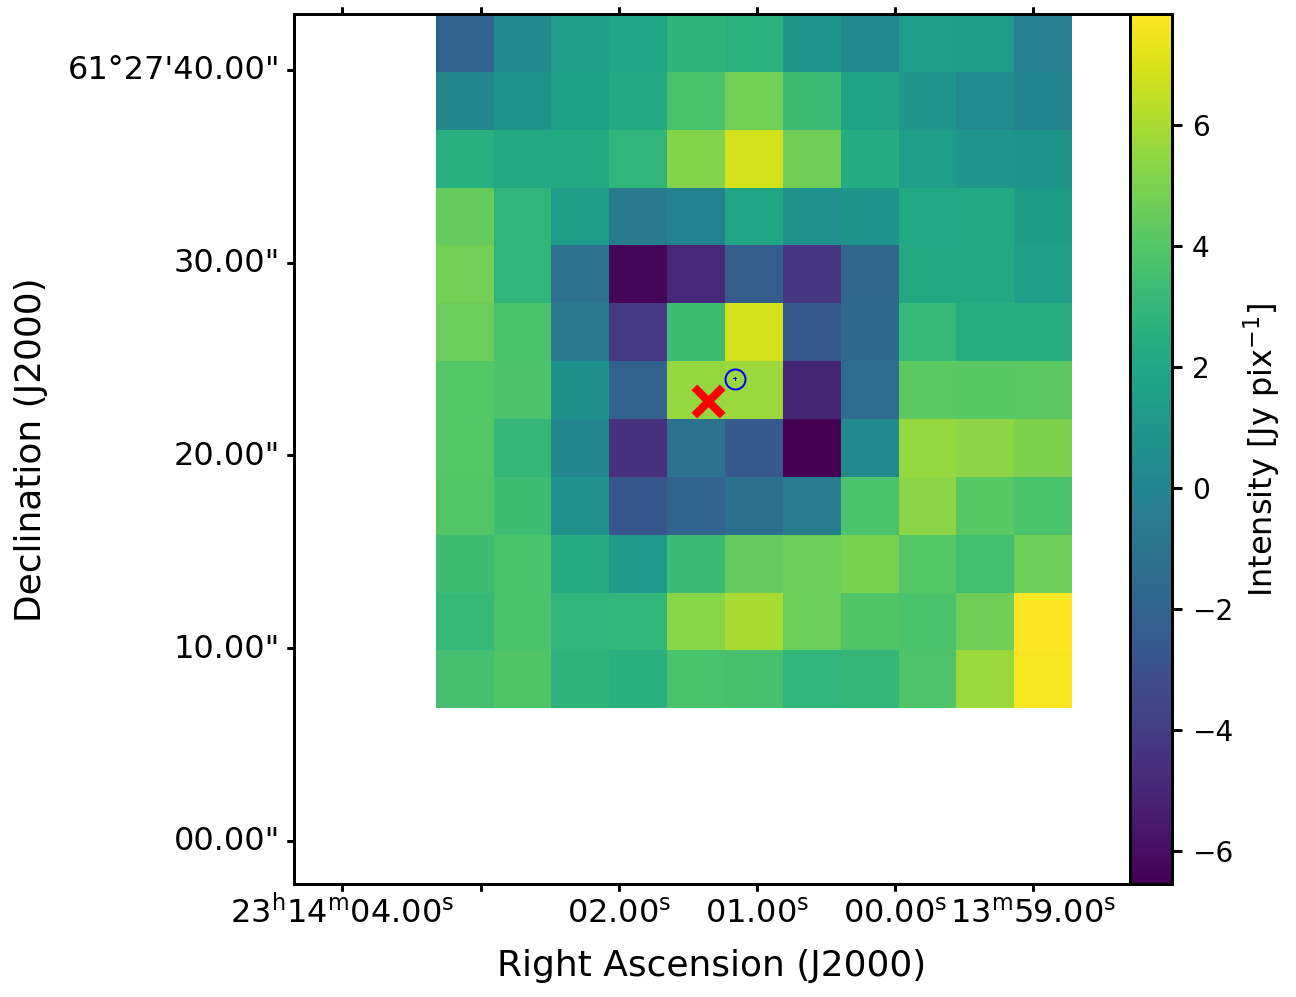

In [212]:
import astropy.io.fits as fits
import os
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
import matplotlib.axes as maxes
from mpl_toolkits.axes_grid1 import make_axes_locatable


s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

im = ax.imshow(cont_im-model_data)
extent = im.get_extent()
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, 
                       extent[2]-y_offset_red, extent[3]-y_offset_red])

# ax.contour(model_data, colors='k')
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

# print the S/N of the continuum
cont_red_noise = np.nanstd(cont_im-model_data)
snr_red = g.amplitude.value/cont_red_noise
print('Gaussian peak = {:<.2f}'.format(g.amplitude.value))
print('Image peak = {:<.2f}'.format(np.nanmax(cont_im)))
print('Noise = {:<.2f}'.format(cont_red_noise))
print('Peak residual = {:<.2f}'.format(np.nanmax(cont_im-model_data)))
print('S/N = {:<.2f}'.format(snr_red))

# from Reid and Honma 2014, thermal noise = 0.5*θ_beam/SNR
beam = 14 * (1.9/ (c/line_wave*1e4/1e12))
print('Thermal noise = {:<.2f} arcsec'.format(0.5*beam/snr_red))

# Masking out the continuum source to estimate the noise

/var/folders/d2/xn0qhb7x2p7gqlvz33zdqrsh0000gn/T/ipykernel_9277/2079096683.py:50: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


Gaussian peak = 110.63
Image peak = 112.92
Noise = 2.31
Peak residual = 10.23
S/N = 47.98
63.18367060032567
Thermal noise = 0.06 arcsec


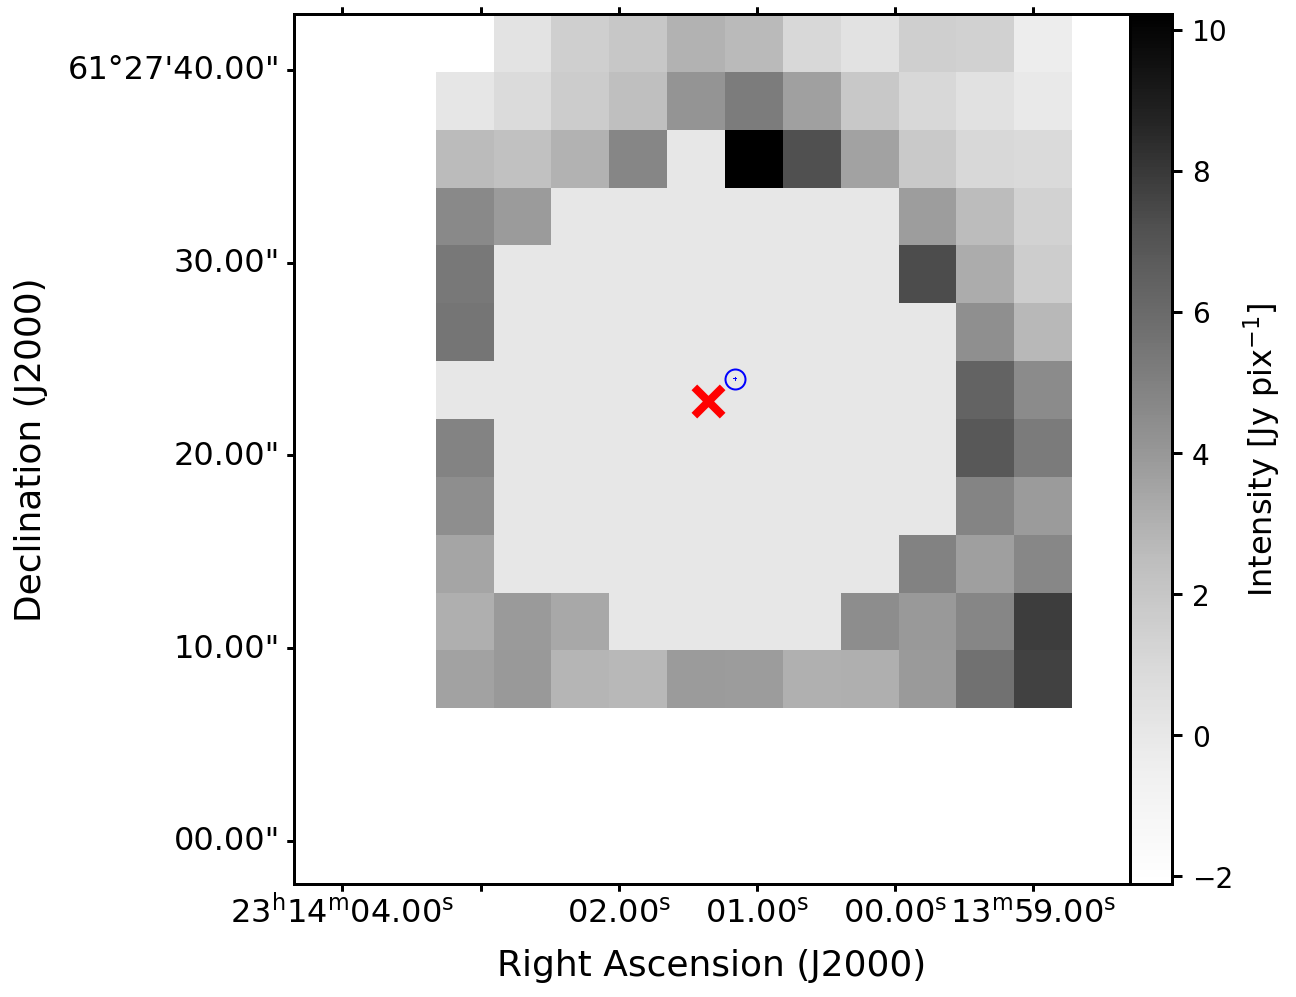

In [213]:
import astropy.io.fits as fits
import os
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
import matplotlib.axes as maxes
from mpl_toolkits.axes_grid1 import make_axes_locatable

s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

# masking
aper = 25.6

x_grid, y_grid = np.meshgrid(np.arange(len(cont_im[0,:])), np.arange(len(cont_im[:,0])))
dist_grid = ((x_grid-s_pix[0]-x_offset_red)**2 + (y_grid-s_pix[1]-y_offset_red)**2)**0.5
aper_pix = aper / ( abs(utils.proj_plane_pixel_scales(w)[0])*3600 )
cont_im_masked = np.where(dist_grid <= aper_pix/2, cont_im, 0.0)
cont_im_bkg = np.where(dist_grid > aper_pix/2, cont_im, 0.0)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

im = ax.imshow(cont_im_bkg, cmap='Greys')
extent = im.get_extent()
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, 
                       extent[2]-y_offset_red, extent[3]-y_offset_red])

# ax.contour(model_data, colors='k')
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

# print the S/N of the continuum
cont_bkg_red_noise = np.nanstd(cont_im_bkg)
snr_red = g.amplitude.value/cont_bkg_red_noise
print('Gaussian peak = {:<.2f}'.format(g.amplitude.value))
print('Image peak = {:<.2f}'.format(np.nanmax(cont_im)))
print('Noise = {:<.2f}'.format(cont_bkg_red_noise))
print('Peak residual = {:<.2f}'.format(np.nanmax(cont_im_bkg)))
print('S/N = {:<.2f}'.format(snr_red))

# from Reid and Honma 2014, thermal noise = 0.5*θ_beam/SNR
print(line_wave)
beam = 14 * (1.9/ (c/line_wave*1e4/1e12))
print('Thermal noise = {:<.2f} arcsec'.format(0.5*beam/snr_red))

In [21]:
beam = 14 * (1.9/ (c/63*1e4/1e12))
print(beam)

5.589867107330632


# Update the offset with uncertainties from thermal noise

In [214]:
from astropy.wcs import utils

x_offset_blue, y_offset_blue = [g.x_mean.value, g.y_mean.value] # in pixel
x_offset_err_blue, y_offset_err_blue = [fit.fit_info['cov_x'][1,1]**0.5, fit.fit_info['cov_x'][2,2]**0.5]
pltscale = utils.proj_plane_pixel_scales(w) # width of a pixel in degree
x_offset_blue_arcsec, y_offset_blue_arcsec = [x_offset_blue*pltscale[0]*3600, y_offset_blue*pltscale[0]*3600]
x_offset_err_blue_arcsec, y_offset_err_blue_arcsec = [x_offset_err_blue*pltscale[0]*3600, y_offset_err_blue*pltscale[0]*3600]

# thermal noise
thermal_noise_red = 0.53
thermal_noise_blue = 0.07
x_offset_err_blue_arcsec = (x_offset_err_blue_arcsec**2+thermal_noise_blue**2)**0.5
y_offset_err_blue_arcsec = (y_offset_err_blue_arcsec**2+thermal_noise_blue**2)**0.5
x_offset_err_red_arcsec = (x_offset_err_red_arcsec**2+thermal_noise_red**2)**0.5
y_offset_err_red_arcsec = (y_offset_err_red_arcsec**2+thermal_noise_red**2)**0.5

# Recall that RA goes from positivie to negative from left to right
print('[BLUE] - Offset in x and y (arcsec, arcsec)   = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_blue_arcsec, x_offset_err_blue_arcsec, 
                                                                                    y_offset_blue_arcsec, y_offset_err_blue_arcsec))
print('[RED]  - Offset in x and y (arcsec, arcsec)   = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_red_arcsec, x_offset_err_red_arcsec,
                                                                                    y_offset_red_arcsec, y_offset_err_red_arcsec))

# convert the offsets in RED to blue
x_offset_red2blue = x_offset_red_arcsec / (pltscale[0]*3600)
y_offset_red2blue = y_offset_red_arcsec / (pltscale[0]*3600)

print('Relatvie offset in x and y (BLUE from RED)    = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_blue_arcsec-x_offset_red_arcsec, 
                                                                                                          (x_offset_err_blue_arcsec**2 + x_offset_err_red_arcsec**2)**0.5,
                                                                                                          y_offset_blue_arcsec-y_offset_red_arcsec,
                                                                                                          (y_offset_err_blue_arcsec**2 + y_offset_err_red_arcsec**2)**0.5))
print('Relatvie offset in RA and Dec (BLUE from RED) = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(-(x_offset_blue_arcsec-x_offset_red_arcsec), 
                                                                                                          (x_offset_err_blue_arcsec**2 + x_offset_err_red_arcsec**2)**0.5,
                                                                                                          y_offset_blue_arcsec-y_offset_red_arcsec,
                                                                                                          (y_offset_err_blue_arcsec**2 + y_offset_err_red_arcsec**2)**0.5))

# print('IF we consider the 1/3 beam size error - ')
# # 14 x (1.9/ v THz)
# red_beam = 14 * (1.9/1.6) / 3 # 185 um (CO 14-13)
# blue_beam = 14 * (1.9/5.8) / 3 # 52 um ([OIII])
# print('Relatvie offset in x and y (BLUE from RED)    = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_blue_arcsec-x_offset_red_arcsec, 
#                                                                                                           (x_offset_err_blue_arcsec**2 + x_offset_err_red_arcsec**2 + blue_beam**2 + red_beam**2)**0.5,
#                                                                                                           y_offset_blue_arcsec-y_offset_red_arcsec,
#                                                                                                           (y_offset_err_blue_arcsec**2 + y_offset_err_red_arcsec**2 + blue_beam**2 + red_beam**2)**0.5))


[BLUE] - Offset in x and y (arcsec, arcsec)   = (-0.90+/- 0.07, -2.80+/- 0.07)
[RED]  - Offset in x and y (arcsec, arcsec)   = (-2.30+/- 0.54, -3.97+/- 0.54)
Relatvie offset in x and y (BLUE from RED)    = ( 1.40+/- 0.55,  1.17+/- 0.55)
Relatvie offset in RA and Dec (BLUE from RED) = (-1.40+/- 0.55,  1.17+/- 0.55)


# Update the astrometry-corrected images

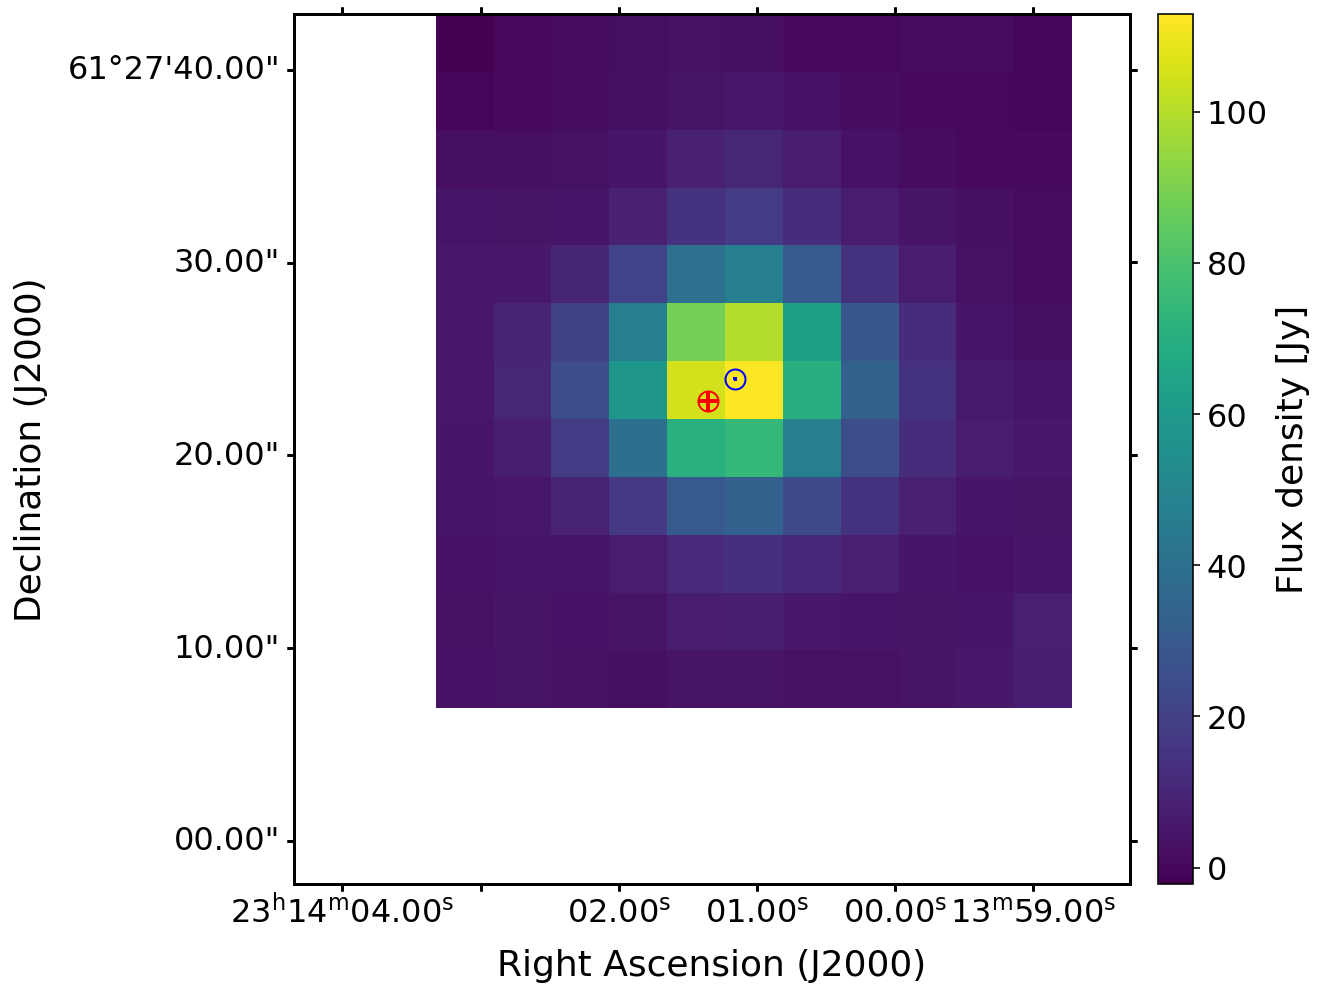

In [215]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.ndimage import shift

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]
pltscale = abs(utils.proj_plane_pixel_scales(w)[0])*3600

s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

# make an image with correction to get the extent
im = ax.imshow(cont_im)
extent = im.get_extent()
# actual image with astrometric correction
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, extent[2]-y_offset_red, extent[3]-y_offset_red])

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

# source position
# ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)
ax.errorbar(s_pix[0], s_pix[1],
            xerr=x_offset_err_red_arcsec/pltscale, 
            yerr=y_offset_err_red_arcsec/pltscale,
            marker='o', color='r', markersize=10, elinewidth=2, mfc='None')

# where the peak of the 2D gaussian supposed to be
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=x_offset_err_blue_arcsec/pltscale, yerr=y_offset_err_blue_arcsec/pltscale,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)


cax = fig.add_axes([0.9,0.125,0.03,0.755])
cb=fig.colorbar(im, cax=cax)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

# Make cont-free spectral cube

In [216]:
# cube = hdu[3].data  # redo the transmission correction
contsub_cube_blue = np.zeros_like(mod_cube)
for i in range(len(mod_cube[:,0,0])):
    contsub_cube_blue[i,:,:] = mod_cube[i,:,:] - cont_im

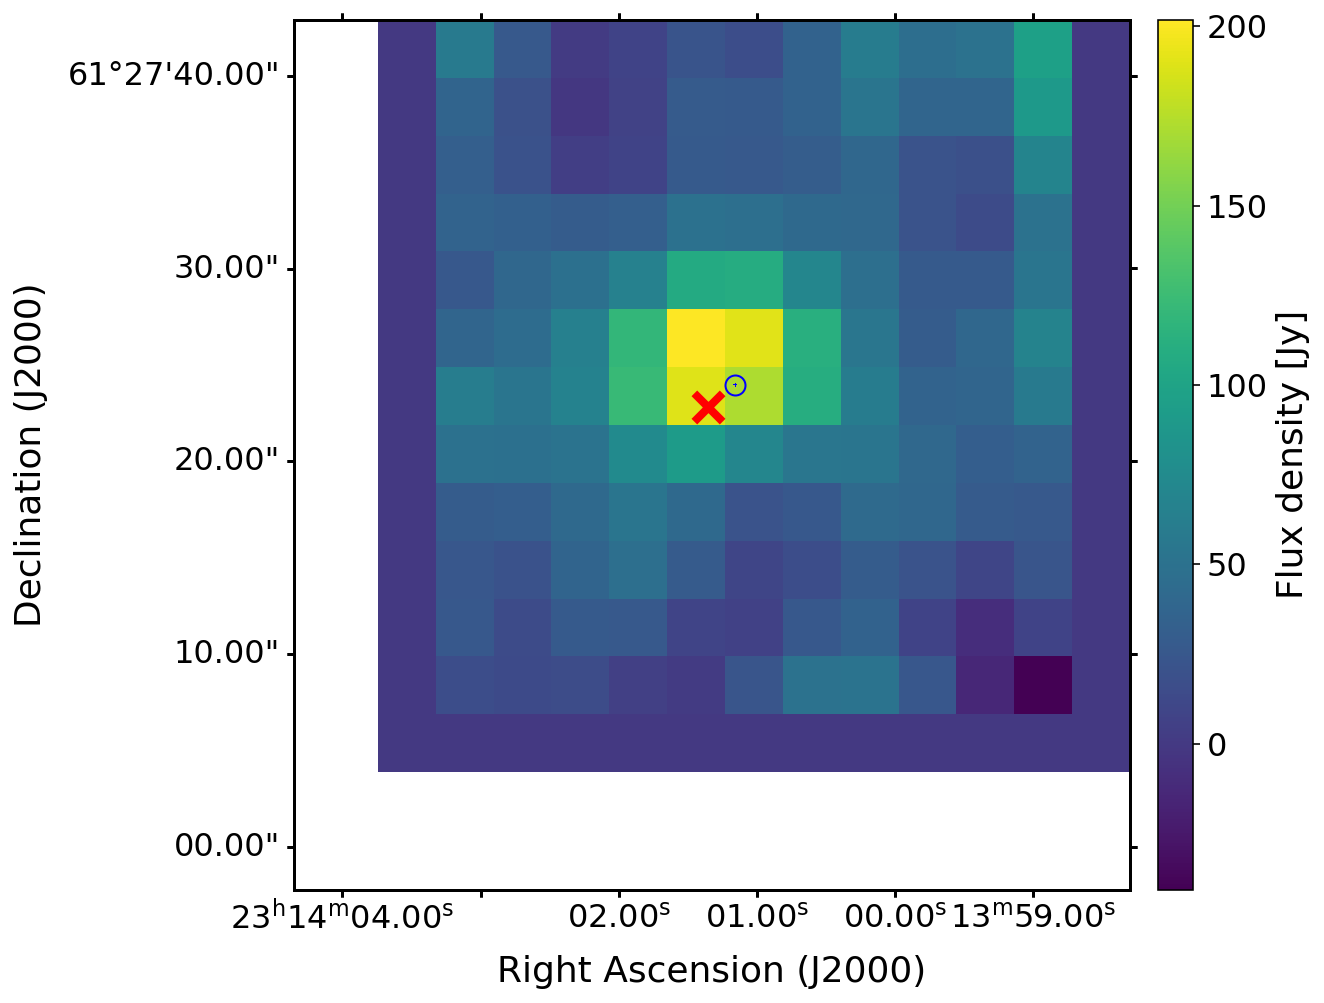

In [217]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.ndimage import shift

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

# find where the line is
velo = (wave-line_wave)/line_wave * c/1e5 - v_source
selector = (velo < 150) & (velo > -150)

# make an image with correction to get the extent
contsub_im = np.nansum(contsub_cube_blue[selector,:,:], axis=0)
im = ax.imshow(contsub_im)
extent = im.get_extent()
# actual image with astrometric correction
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, extent[2]-y_offset_red, extent[3]-y_offset_red])

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

# source position
ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# where the peak of the 2D gaussian supposed to be
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)


cax = fig.add_axes([0.9,0.125,0.03,0.755])
cb=fig.colorbar(im, cax=cax)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

# Make blue- and red- integrated intensity

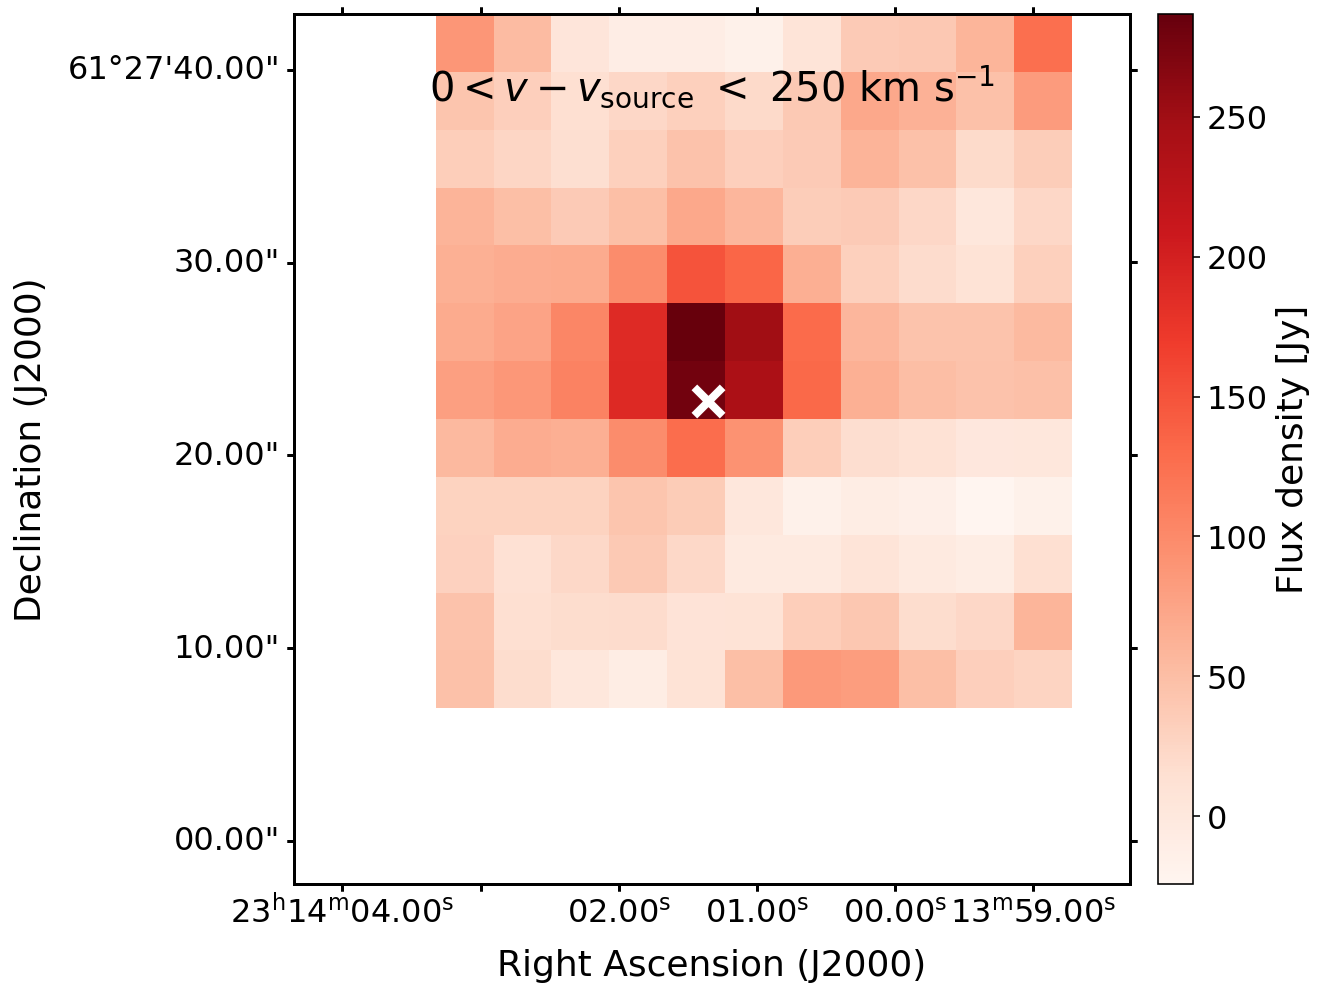

In [220]:
coords = SkyCoord(source_coord, unit=(u.hourangle, u.degree), equinox='J2000') 

wcs = WCS(naxis=2)
wcs.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
wcs.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
wcs.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
wcs.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

# Churchwell+1992: 13CO 1-0 -> 39.4; 13CO 2-1 -> 39.9; CS 2-1 -> 39.7; CS 5-4 -> 38.5
v_source = 39.4 # km/s
iwave = np.argsort(abs(line_waves-np.mean(wave)))[0]
line_wave = line_waves[iwave]

velo = (wave-line_wave)/line_wave * c/1e5 - v_source
velo_red = (velo > 0) & (velo < 250)
velo_blue = (velo < 0) & (velo > -250)

wave_indice = np.arange(0, len(contsub_cube_blue[:,0,0]))
red_indice = wave_indice[velo_red]
blue_indice = wave_indice[velo_blue]

fig = make_image(np.sum(contsub_cube_blue[red_indice,:,:], axis=0), coords, wcs, 
                 astrometry_corr=[x_offset_red, y_offset_red], 
                 velo_label=r'$0 < v - v_{\rm source}$ $<$ 250 km s$^{-1}$', cmap='Reds')
fig.savefig('/Users/yaolun/Dropbox/research/SOMA-FIR/NGC7538/OI63_red.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

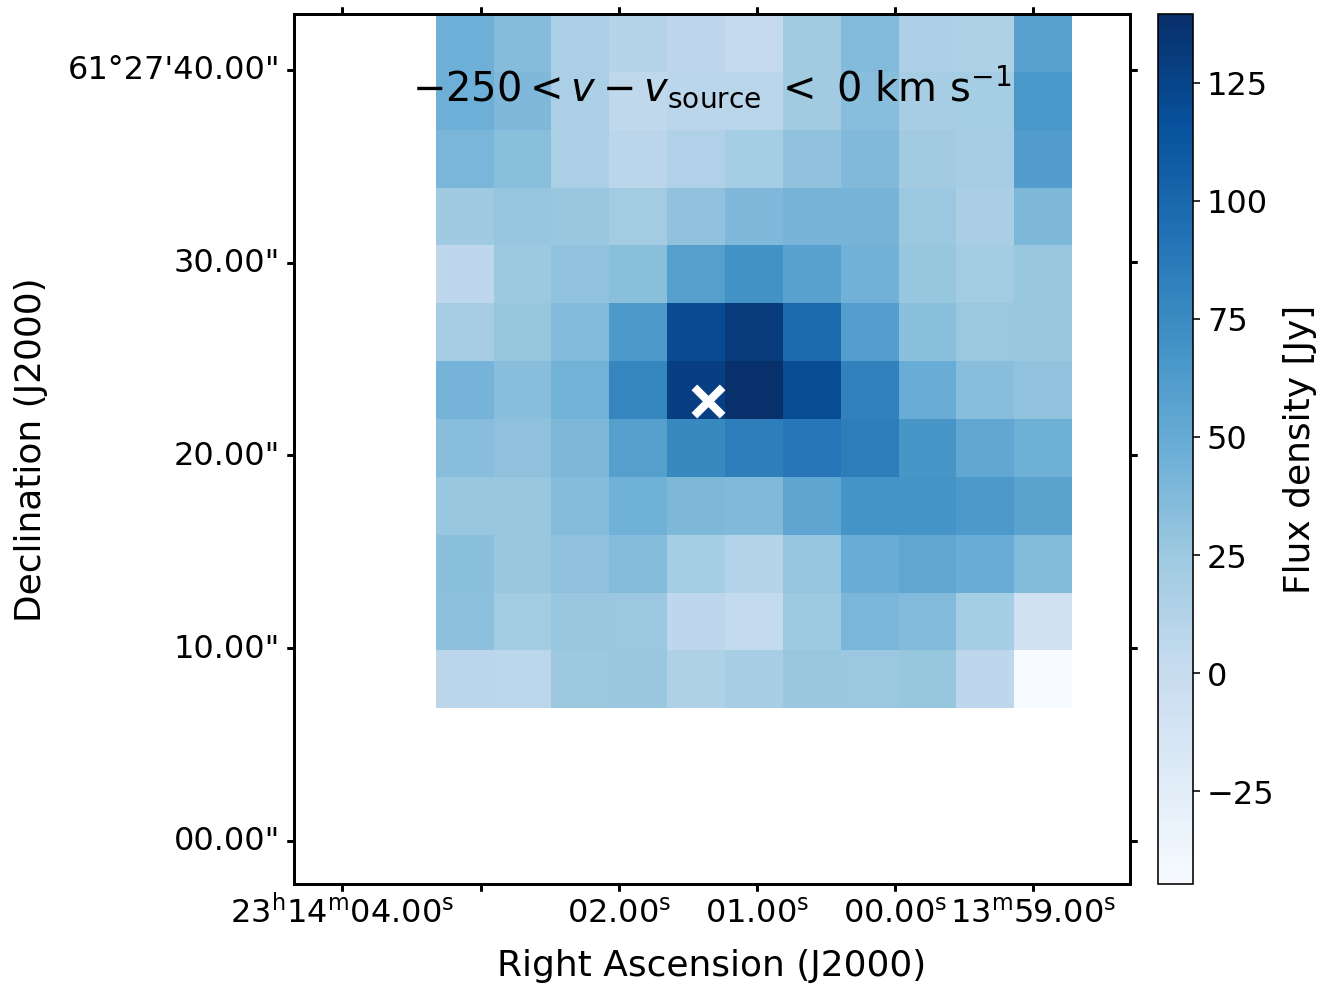

In [221]:
fig = make_image(np.sum(contsub_cube_blue[blue_indice,:,:], axis=0), coords, wcs, 
                 astrometry_corr=[x_offset_red, y_offset_red], 
                 velo_label=r'$-250 < v - v_{\rm source}$ $<$ 0 km s$^{-1}$', cmap='Blues')
fig.savefig('/Users/yaolun/Dropbox/research/SOMA-FIR/NGC7538/OI63_blue.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

# SED

In [31]:
from astropy.io import ascii
import numpy as np

sed = ascii.read('/Users/yaolun/Dropbox/research/SOMA/SOMA_I_SEDs/NGC7538SED.txt', names=['wave', 'f1', 'f2', 'vf1', 'vf2', 'f3', 'f4', 'vf3', 'vf4'])

In [28]:
flux = ascii.read('/Users/yaolun/Dropbox/research/SOMA-FIR/NGC7538 flux.txt')

In [29]:
flux

Wavelength,Flux,Error
float64,float64,float64
145.0,895.7361527950486,147.08540389275896
63.0,771.8544215167998,98.57372376228241
185.0,583.5449229925075,124.67691595818815
52.0,1118.8395336370927,211.49680727295913


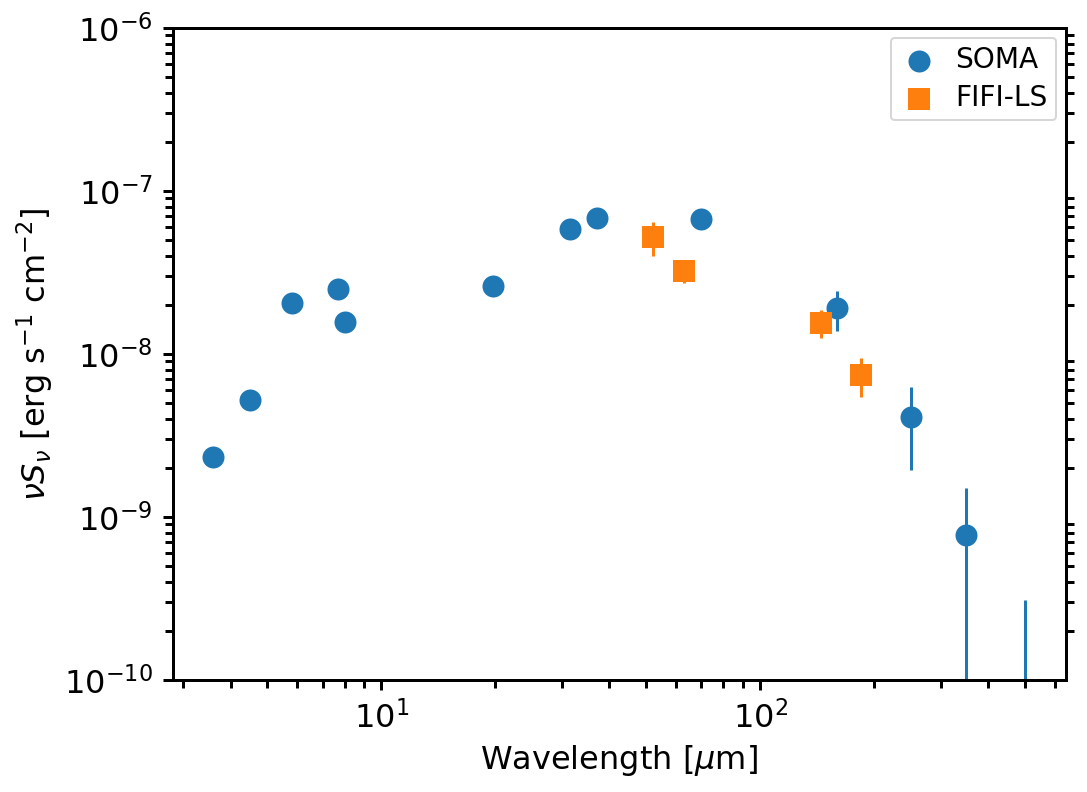

In [38]:
import astropy.constants as const
import matplotlib.pyplot as plt
c = const.c.cgs.value

fifils_wave = np.array([52, 63, 145, 185])
fifils_flux = np.array([895.7361527950486, 771.8544215167998, 583.5449229925075, 1118.8395336370927])
fifils_err_flux = np.array([147.08540389275896, 98.57372376228241, 124.67691595818815, 211.49680727295913])

fig = plt.figure()
ax = fig.add_subplot(111)

ax.errorbar(sed['wave'], sed['f1']*c/sed['wave']*1e4*1e-23, yerr=(sed['f2']-sed['f1'])*c/sed['wave']*1e4*1e-23, marker='o', markersize=10, linestyle='None', label='SOMA')
ax.errorbar(flux['Wavelength'], (flux['Flux']-flux['Error'])*c/flux['Wavelength']*1e4*1e-23, yerr=flux['Error']*c/flux['Wavelength']*1e4*1e-23, marker='s', markersize=10, linestyle='None', label='FIFI-LS')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-10, 1e-6)
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'$\nu S_{\nu}$ [erg s$^{-1}$ cm$^{-2}$]')
ax.legend(loc='best')

fig, ax = publish(fig, useoffset=None)
fig.savefig('/Users/yaolun/Dropbox/research/SOMA-FIR/NGC7538/sed.pdf', format='pdf', dpi=300, bbox_inches='tight')